In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [3]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [4]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [5]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=16.txt", 'r')
Lines= file.readlines()
c_d16=[]
count = 0
for line in Lines:
    c_d16.append(line)
    count += 1
print (count)
count=0


file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/XX/d=32.txt", 'r')
Lines= file.readlines()
c_d32=[]
count = 0
for line in Lines:
    c_d32.append(line)
    count += 1
print (count)
count=0



20
20
20
20
20


In [6]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames_d16=[]
filenames_d32=[]
filenames_d2_0703=[]
filenames_d4_0703=[]
filenames_d8_0703=[]
filenames_d2_rerun=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)


paf_data_d2_0703="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB 01+10 d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2_0703):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2_0703.append(filenames[i])
            break
print (filenames_d2_0703)

paf_data_d2_rerun="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-12 EAB__d=2_rerun/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2_rerun):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2_rerun.append(filenames[i])
            break
print (filenames_d2_rerun)


paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)



paf_data_d4_0703="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB 01+10 d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4_0703):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4_0703.append(filenames[i])
            break
print (filenames_d4_0703)

paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)

paf_data_d8_0703="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0703/2023-07-03 EAB__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8_0703):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8_0703.append(filenames[i])
            break
print (filenames_d8_0703)

paf_data_d16="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=16/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d16 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d16.append(filenames[i])
            break
print (filenames_d16)

paf_data_d32="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/2023-07-11 EAB__d=32/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d32 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d32.append(filenames[i])
            break
print (filenames_d32)

['2023-07-11-185411_Line_001.txt', '2023-07-11-185434_Line_002.txt', '2023-07-11-185457_Line_003.txt', '2023-07-11-190129_Line_004.txt', '2023-07-11-190153_Line_005.txt', '2023-07-11-190216_Line_006.txt', '2023-07-11-190240_Line_007.txt', '2023-07-11-190907_Line_008.txt', '2023-07-11-190931_Line_009.txt', '2023-07-11-190955_Line_010.txt', '2023-07-11-191018_Line_011.txt', '2023-07-11-232016_Line_012.txt', '2023-07-11-232040_Line_013.txt', '2023-07-11-232103_Line_014.txt', '2023-07-11-232126_Line_015.txt', '2023-07-11-232309_Line_016.txt', '2023-07-11-232332_Line_017.txt', '2023-07-11-232355_Line_018.txt', '2023-07-11-232418_Line_019.txt', '2023-07-11-232601_Line_020.txt']
['2023-07-03-171416_Line_001.txt', '2023-07-03-171452_Line_002.txt', '2023-07-03-171528_Line_003.txt', '2023-07-03-171606_Line_004.txt', '2023-07-03-171803_Line_005.txt', '2023-07-03-171839_Line_006.txt', '2023-07-03-171918_Line_007.txt', '2023-07-03-171955_Line_008.txt', '2023-07-03-172151_Line_009.txt', '2023-07-03-

In [7]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

a_0703=Quantum_State(5)
a_rerun=Quantum_State(5)

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

spam2=SPAM_Operator(5)
spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


2023-07-11-185411_Line_001.txt


/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/SPAM.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  temp.population=np.linalg.lstsq(self.matrix,state.population)[0]


counts: [1, 25, 70, 1603, 3, 6, 36, 92, 2, 30, 6, 100, 1, 9, 7, 10]
counts_ibm_mapping_dic: {'0000': 1, '1000': 25, '0100': 70, '1100': 1603, '0010': 3, '1010': 6, '0110': 36, '1110': 92, '0001': 2, '1001': 30, '0101': 6, '1101': 100, '0011': 1, '1011': 9, '0111': 7, '1111': 10}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



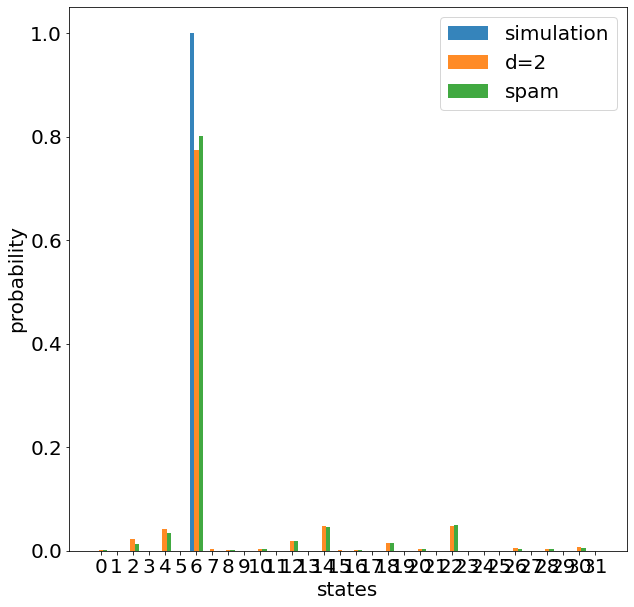

2023-07-11-185434_Line_002.txt
counts: [143, 30, 4, 9, 1618, 90, 1, 3, 14, 1, 2, 1, 58, 7, 16, 3]
counts_ibm_mapping_dic: {'0000': 143, '1000': 30, '0100': 4, '1100': 9, '0010': 1618, '1010': 90, '0110': 1, '1110': 3, '0001': 14, '1001': 1, '0101': 2, '1101': 1, '0011': 58, '1011': 7, '0111': 16, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



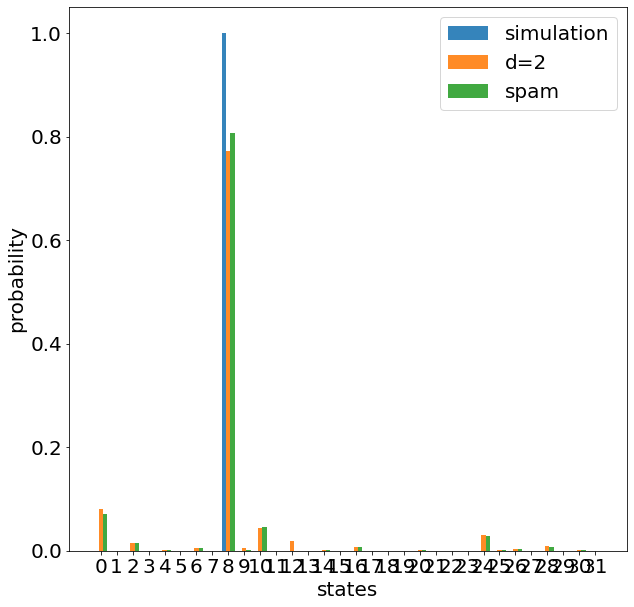

2023-07-11-185457_Line_003.txt
counts: [208, 33, 8, 4, 1394, 79, 6, 83, 36, 3, 4, 2, 94, 13, 19, 13]
counts_ibm_mapping_dic: {'0000': 208, '1000': 33, '0100': 8, '1100': 4, '0010': 1394, '1010': 79, '0110': 6, '1110': 83, '0001': 36, '1001': 3, '0101': 4, '1101': 2, '0011': 94, '1011': 13, '0111': 19, '1111': 13}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



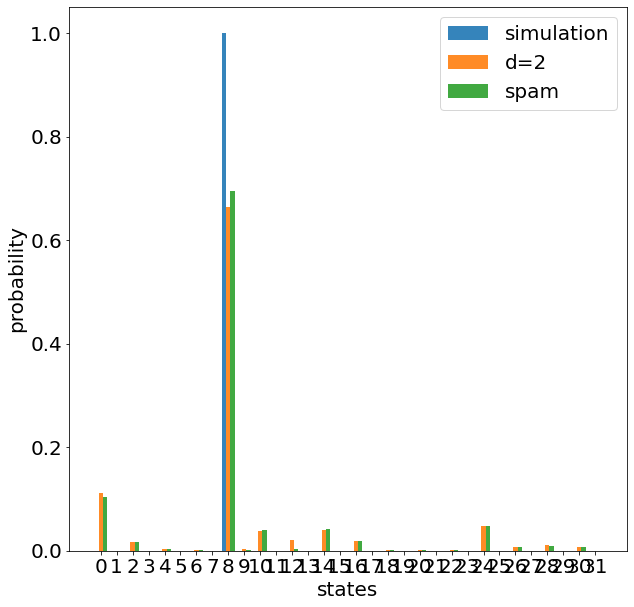

2023-07-11-190129_Line_004.txt
counts: [1, 49, 11, 37, 6, 8, 2, 1, 50, 1627, 7, 60, 60, 78, 0, 1]
counts_ibm_mapping_dic: {'0000': 1, '1000': 49, '0100': 11, '1100': 37, '0010': 6, '1010': 8, '0110': 2, '1110': 1, '0001': 50, '1001': 1627, '0101': 7, '1101': 60, '0011': 60, '1011': 78, '0111': 0, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



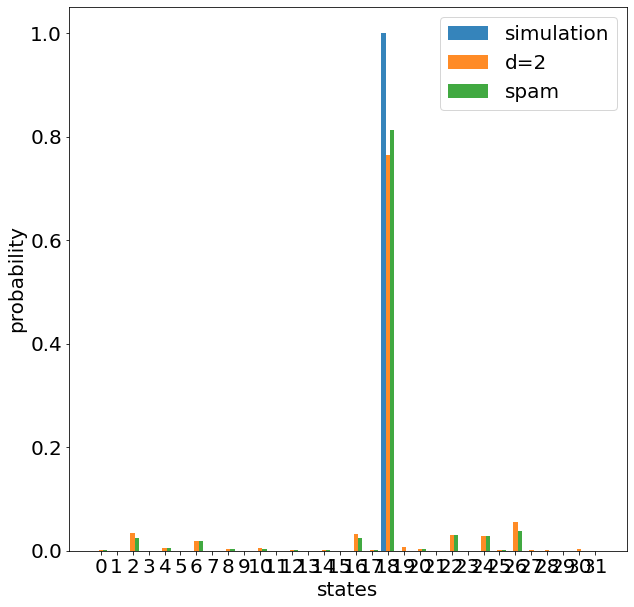

2023-07-11-190153_Line_005.txt
counts: [0, 29, 6, 124, 2, 1, 2, 13, 8, 21, 24, 1687, 8, 3, 27, 44]
counts_ibm_mapping_dic: {'0000': 0, '1000': 29, '0100': 6, '1100': 124, '0010': 2, '1010': 1, '0110': 2, '1110': 13, '0001': 8, '1001': 21, '0101': 24, '1101': 1687, '0011': 8, '1011': 3, '0111': 27, '1111': 44}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



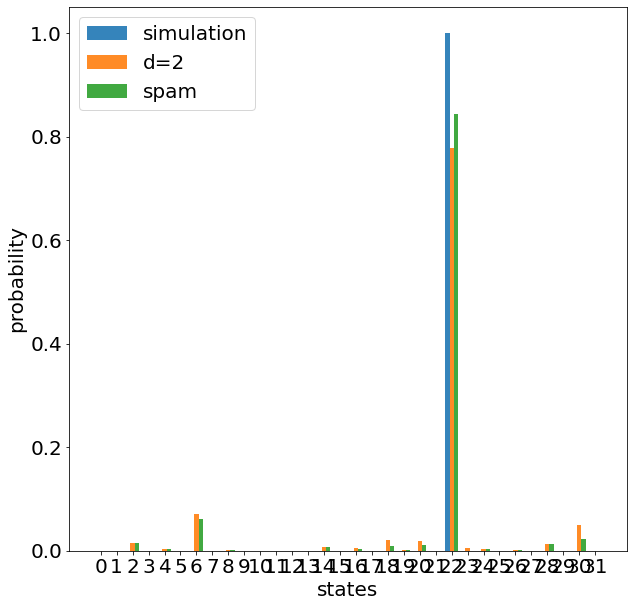

2023-07-11-190216_Line_006.txt
counts: [24, 74, 3, 7, 25, 1749, 4, 3, 3, 4, 2, 1, 1, 80, 0, 20]
counts_ibm_mapping_dic: {'0000': 24, '1000': 74, '0100': 3, '1100': 7, '0010': 25, '1010': 1749, '0110': 4, '1110': 3, '0001': 3, '1001': 4, '0101': 2, '1101': 1, '0011': 1, '1011': 80, '0111': 0, '1111': 20}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



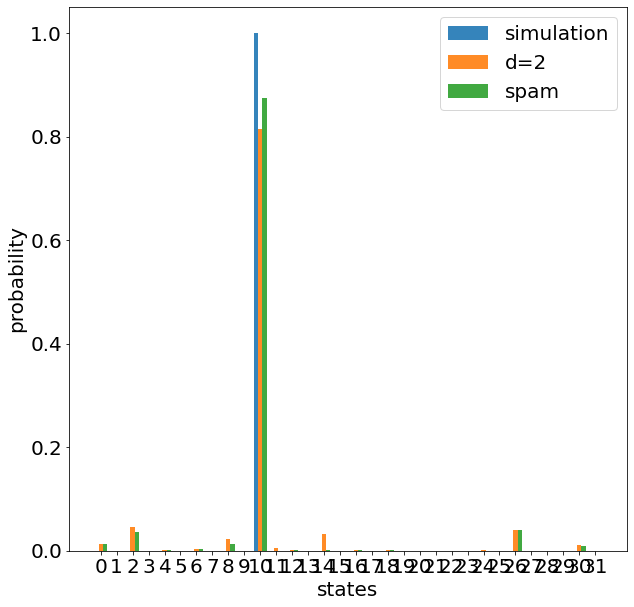

2023-07-11-190240_Line_007.txt
counts: [0, 3, 0, 16, 0, 32, 5, 83, 2, 11, 25, 126, 11, 59, 56, 1569]
counts_ibm_mapping_dic: {'0000': 0, '1000': 3, '0100': 0, '1100': 16, '0010': 0, '1010': 32, '0110': 5, '1110': 83, '0001': 2, '1001': 11, '0101': 25, '1101': 126, '0011': 11, '1011': 59, '0111': 56, '1111': 1569}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



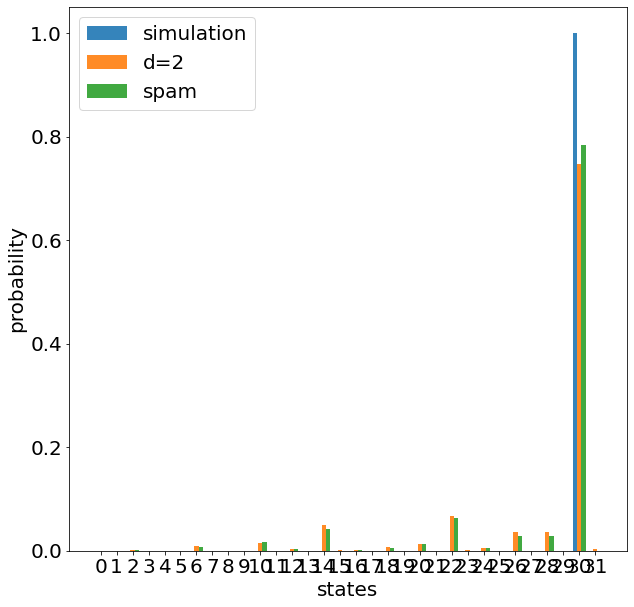

2023-07-11-190907_Line_008.txt
counts: [97, 5, 19, 13, 24, 2, 6, 4, 1461, 34, 40, 62, 192, 30, 5, 6]
counts_ibm_mapping_dic: {'0000': 97, '1000': 5, '0100': 19, '1100': 13, '0010': 24, '1010': 2, '0110': 6, '1110': 4, '0001': 1461, '1001': 34, '0101': 40, '1101': 62, '0011': 192, '1011': 30, '0111': 5, '1111': 6}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RX+21:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



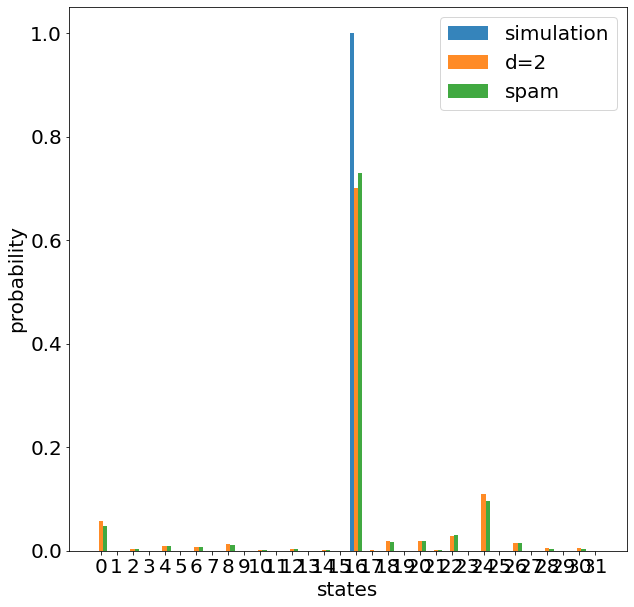

2023-07-11-190931_Line_009.txt
counts: [103, 2, 19, 5, 32, 1, 5, 1, 1433, 34, 37, 92, 185, 29, 10, 11]
counts_ibm_mapping_dic: {'0000': 103, '1000': 2, '0100': 19, '1100': 5, '0010': 32, '1010': 1, '0110': 5, '1110': 1, '0001': 1433, '1001': 34, '0101': 37, '1101': 92, '0011': 185, '1011': 29, '0111': 10, '1111': 11}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



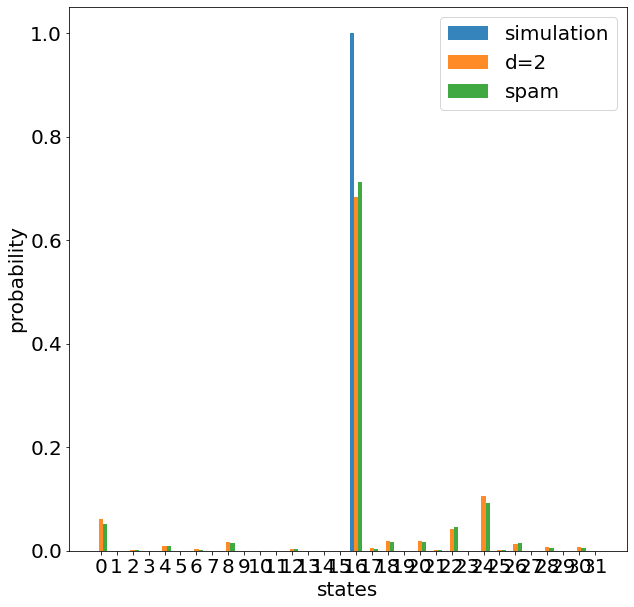

2023-07-11-190955_Line_010.txt
counts: [18, 2, 2, 17, 65, 9, 18, 27, 126, 31, 8, 15, 1534, 64, 14, 50]
counts_ibm_mapping_dic: {'0000': 18, '1000': 2, '0100': 2, '1100': 17, '0010': 65, '1010': 9, '0110': 18, '1110': 27, '0001': 126, '1001': 31, '0101': 8, '1101': 15, '0011': 1534, '1011': 64, '0111': 14, '1111': 50}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



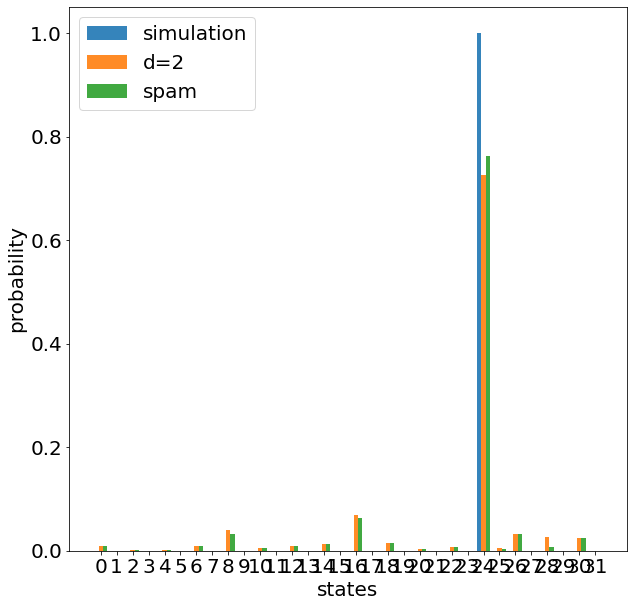

2023-07-11-191018_Line_011.txt
counts: [27, 1600, 8, 58, 21, 114, 1, 2, 3, 113, 6, 22, 3, 18, 2, 4]
counts_ibm_mapping_dic: {'0000': 27, '1000': 1600, '0100': 8, '1100': 58, '0010': 21, '1010': 114, '0110': 1, '1110': 2, '0001': 3, '1001': 113, '0101': 6, '1101': 22, '0011': 3, '1011': 18, '0111': 2, '1111': 4}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



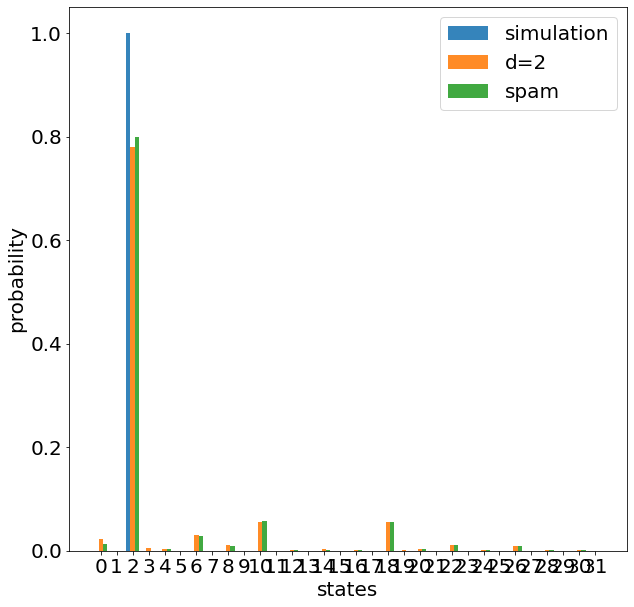

2023-07-11-232016_Line_012.txt
counts: [3, 2, 11, 1, 16, 2, 91, 4, 5, 21, 175, 30, 44, 1, 1540, 54]
counts_ibm_mapping_dic: {'0000': 3, '1000': 2, '0100': 11, '1100': 1, '0010': 16, '1010': 2, '0110': 91, '1110': 4, '0001': 5, '1001': 21, '0101': 175, '1101': 30, '0011': 44, '1011': 1, '0111': 1540, '1111': 54}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



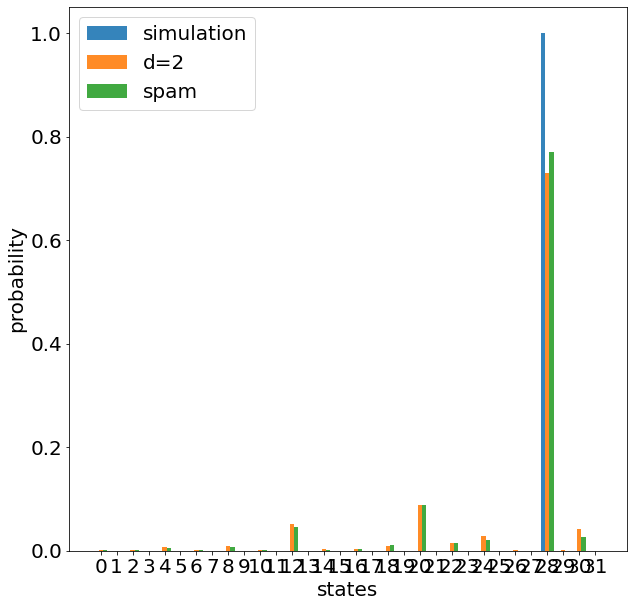

2023-07-11-232040_Line_013.txt
counts: [15, 4, 5, 6, 49, 1, 17, 21, 142, 26, 5, 12, 1581, 72, 0, 45]
counts_ibm_mapping_dic: {'0000': 15, '1000': 4, '0100': 5, '1100': 6, '0010': 49, '1010': 1, '0110': 17, '1110': 21, '0001': 142, '1001': 26, '0101': 5, '1101': 12, '0011': 1581, '1011': 72, '0111': 0, '1111': 45}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



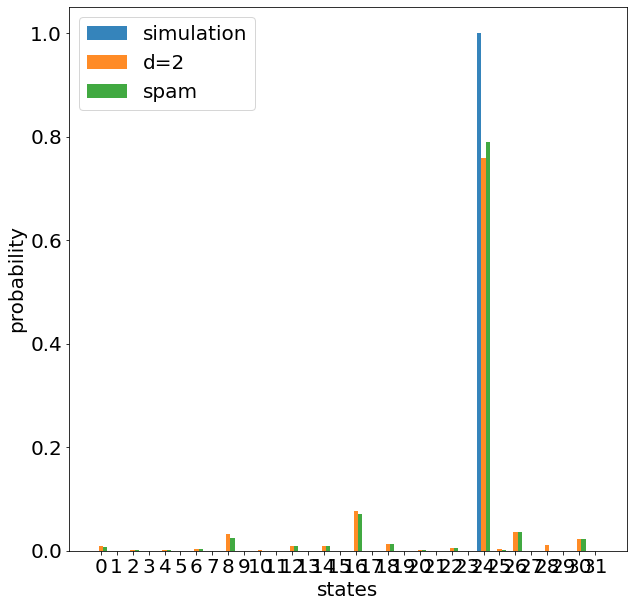

2023-07-11-232103_Line_014.txt
counts: [41, 21, 19, 1612, 18, 2, 38, 80, 29, 29, 2, 89, 1, 6, 2, 11]
counts_ibm_mapping_dic: {'0000': 41, '1000': 21, '0100': 19, '1100': 1612, '0010': 18, '1010': 2, '0110': 38, '1110': 80, '0001': 29, '1001': 29, '0101': 2, '1101': 89, '0011': 1, '1011': 6, '0111': 2, '1111': 11}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



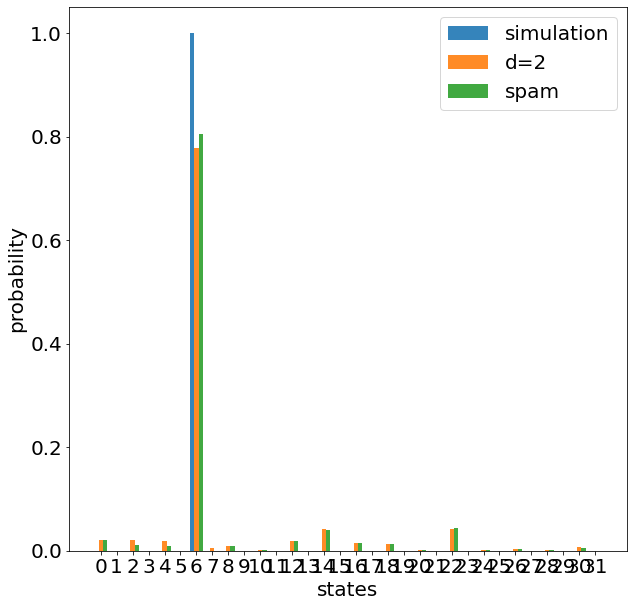

2023-07-11-232126_Line_015.txt
counts: [47, 3, 18, 3, 17, 3, 3, 7, 1670, 14, 30, 0, 136, 37, 1, 13]
counts_ibm_mapping_dic: {'0000': 47, '1000': 3, '0100': 18, '1100': 3, '0010': 17, '1010': 3, '0110': 3, '1110': 7, '0001': 1670, '1001': 14, '0101': 30, '1101': 0, '0011': 136, '1011': 37, '0111': 1, '1111': 13}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



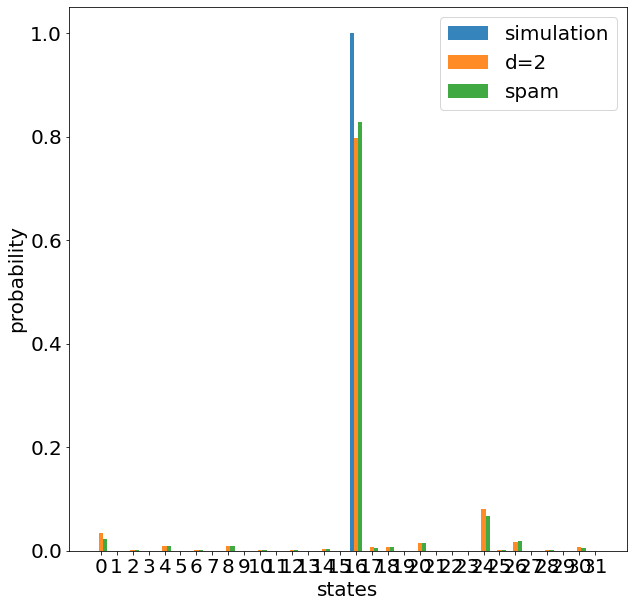

2023-07-11-232309_Line_016.txt
counts: [28, 24, 20, 1578, 18, 3, 44, 70, 2, 30, 1, 163, 1, 3, 2, 14]
counts_ibm_mapping_dic: {'0000': 28, '1000': 24, '0100': 20, '1100': 1578, '0010': 18, '1010': 3, '0110': 44, '1110': 70, '0001': 2, '1001': 30, '0101': 1, '1101': 163, '0011': 1, '1011': 3, '0111': 2, '1111': 14}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



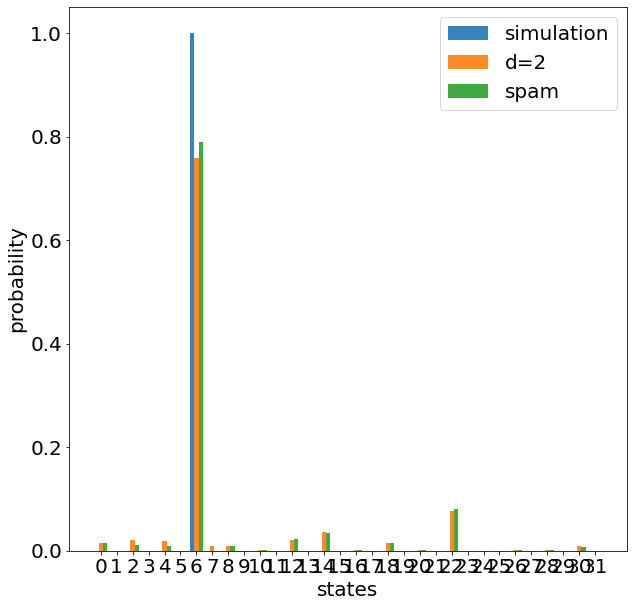

2023-07-11-232332_Line_017.txt
counts: [52, 1, 21, 15, 12, 2, 10, 3, 1520, 30, 30, 34, 226, 35, 5, 6]
counts_ibm_mapping_dic: {'0000': 52, '1000': 1, '0100': 21, '1100': 15, '0010': 12, '1010': 2, '0110': 10, '1110': 3, '0001': 1520, '1001': 30, '0101': 30, '1101': 34, '0011': 226, '1011': 35, '0111': 5, '1111': 6}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



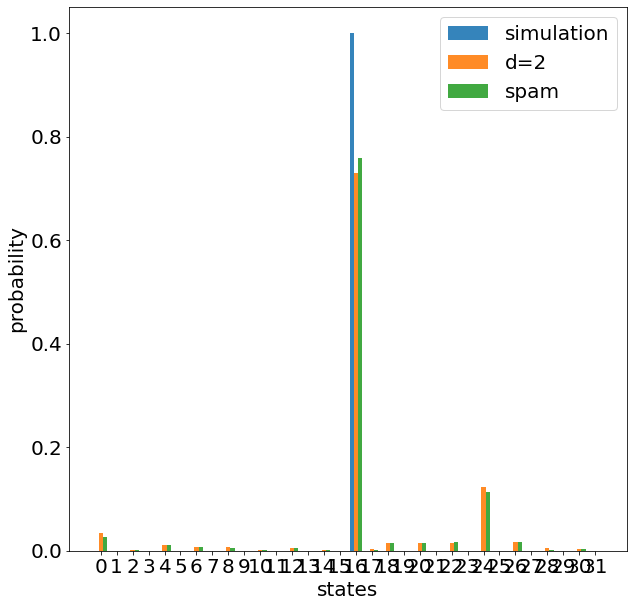

2023-07-11-232355_Line_018.txt
counts: [148, 26, 8, 5, 1637, 65, 0, 32, 16, 2, 2, 1, 43, 1, 14, 2]
counts_ibm_mapping_dic: {'0000': 148, '1000': 26, '0100': 8, '1100': 5, '0010': 1637, '1010': 65, '0110': 0, '1110': 32, '0001': 16, '1001': 2, '0101': 2, '1101': 1, '0011': 43, '1011': 1, '0111': 14, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



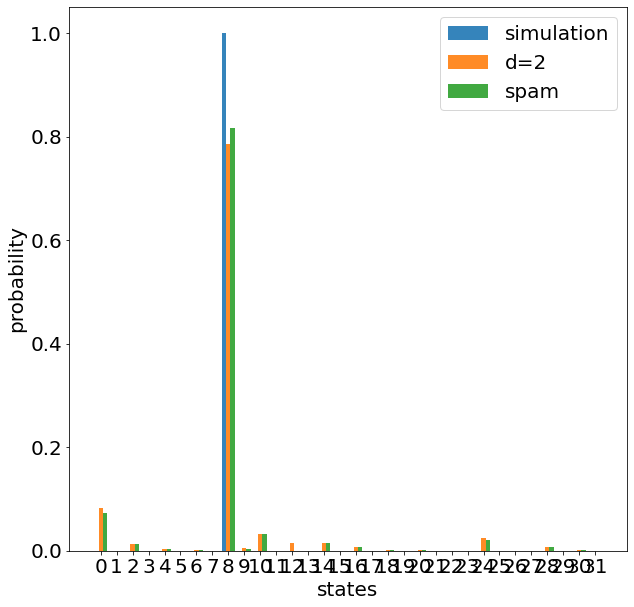

2023-07-11-232418_Line_019.txt
counts: [11, 1746, 10, 41, 37, 56, 7, 0, 0, 46, 7, 21, 4, 5, 5, 2]
counts_ibm_mapping_dic: {'0000': 11, '1000': 1746, '0100': 10, '1100': 41, '0010': 37, '1010': 56, '0110': 7, '1110': 0, '0001': 0, '1001': 46, '0101': 7, '1101': 21, '0011': 4, '1011': 5, '0111': 5, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



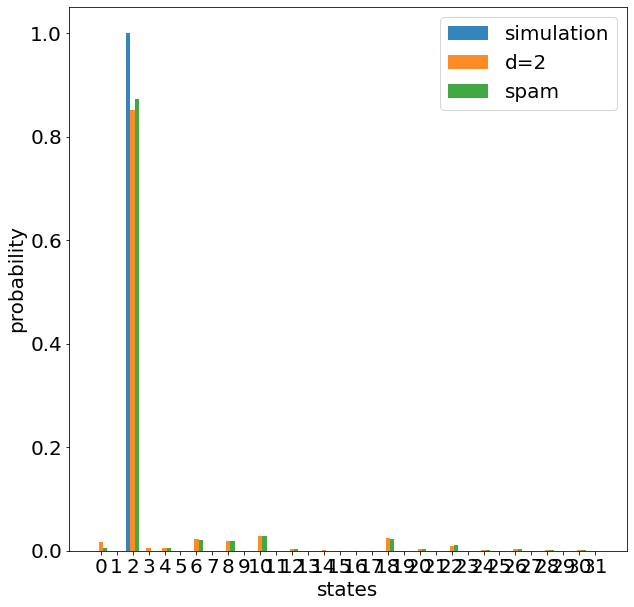

2023-07-11-232601_Line_020.txt
counts: [5, 2, 5, 4, 47, 2, 13, 11, 148, 12, 10, 3, 1664, 63, 2, 8]
counts_ibm_mapping_dic: {'0000': 5, '1000': 2, '0100': 5, '1100': 4, '0010': 47, '1010': 2, '0110': 13, '1110': 11, '0001': 148, '1001': 12, '0101': 10, '1101': 3, '0011': 1664, '1011': 63, '0111': 2, '1111': 8}
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



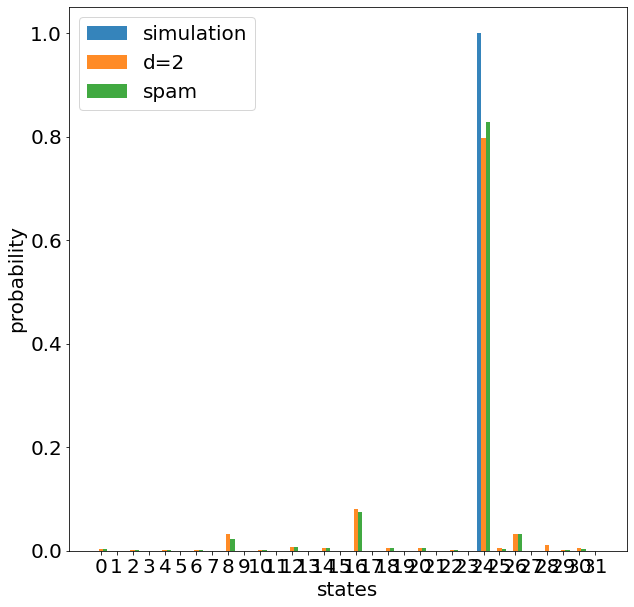

In [8]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
counts_d2_sim=[]
shots=2000
counts=[]
counts_spam=[]
counts_sim=[]
filenames_data=filenames_d2.copy()
# print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    if (i<11):
        a_s=spam1.Correct_SPAM(a)
    else:
        a_s=spam2.Correct_SPAM(a)
    data_traced=Trace_Out(a_s,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)

#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)

#     a_0703.Import(paf_data_d2_0703+filenames_d2_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
#     a_rerun.Import(paf_data_d2_rerun+filenames_d2_rerun[i],keep_file=True)
#     data_rerun_traced=Trace_Out(a_rerun,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    counts_sim=[round(shots*x) for x in sim_traced.population]
    counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
    counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
    Display_States_Population(states=[b,a,a_s],label=["simulation","d=2","spam"])
#     Display_States_Population(states=[sim_traced,data_traced,data_0703_traced,data_rerun_traced],label=["sim_traced","data_traced","0703_traced","0711rerun"])
# #       


['2023-07-11-200423_Line_001.txt', '2023-07-11-200451_Line_002.txt', '2023-07-11-200519_Line_003.txt', '2023-07-11-202731_Line_004.txt', '2023-07-11-202442_Line_005.txt', '2023-07-11-202824_Line_006.txt', '2023-07-11-203010_Line_007.txt', '2023-07-11-203037_Line_008.txt', '2023-07-11-203104_Line_009.txt', '2023-07-11-203250_Line_010.txt', '2023-07-11-203318_Line_011.txt', '2023-07-11-203345_Line_012.txt', '2023-07-11-233143_Line_013.txt', '2023-07-11-233210_Line_014.txt', '2023-07-11-233237_Line_015.txt', '2023-07-11-233423_Line_016.txt', '2023-07-11-233450_Line_017.txt', '2023-07-11-233517_Line_018.txt', '2023-07-12-000518_Line_019.txt', '2023-07-12-000544_Line_020.txt']
2023-07-11-200423_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ

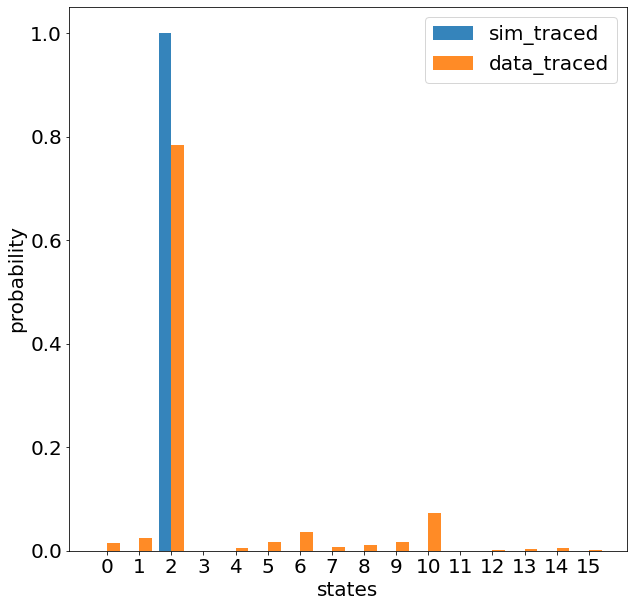

2023-07-11-200451_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



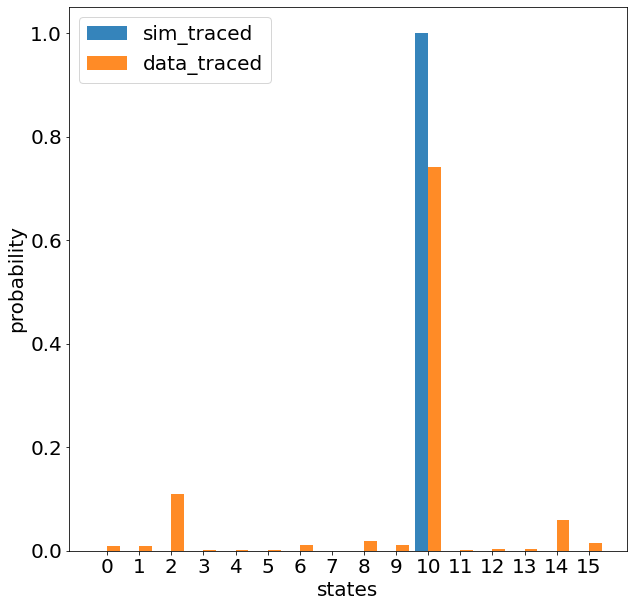

2023-07-11-200519_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



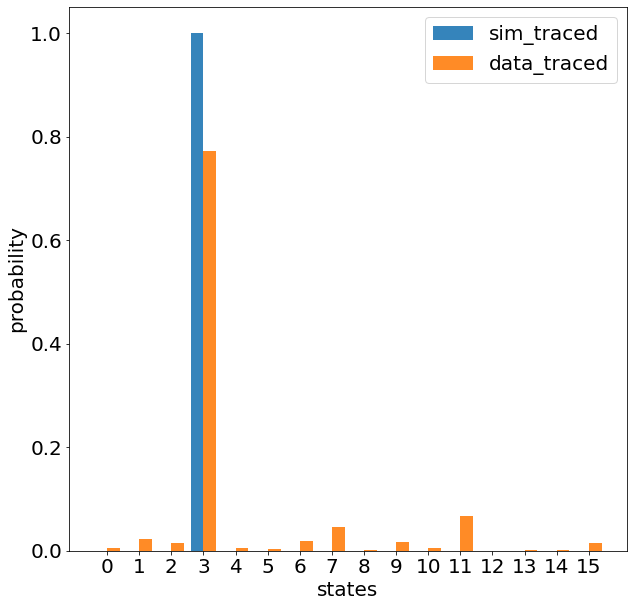

2023-07-11-202731_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



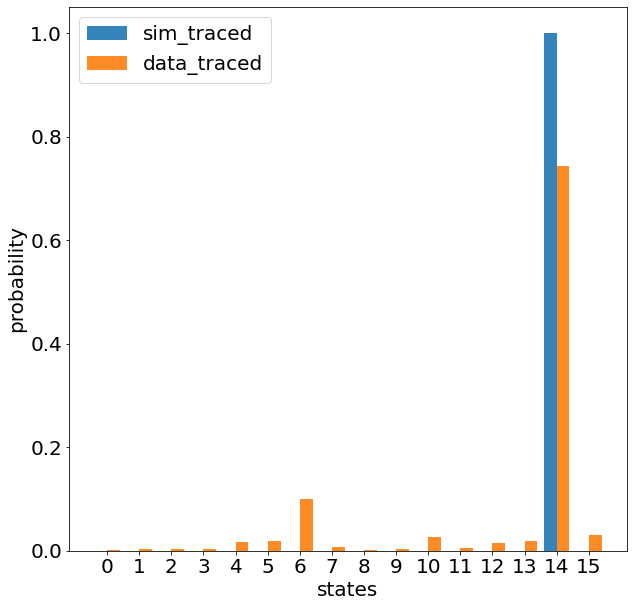

2023-07-11-202442_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



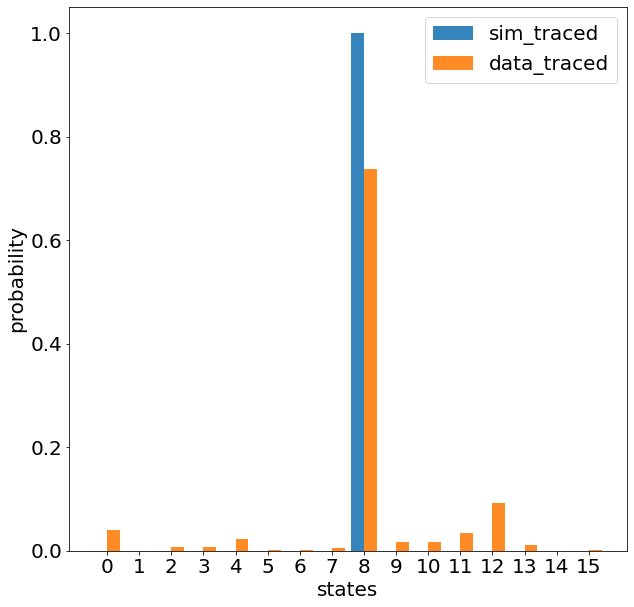

2023-07-11-202824_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



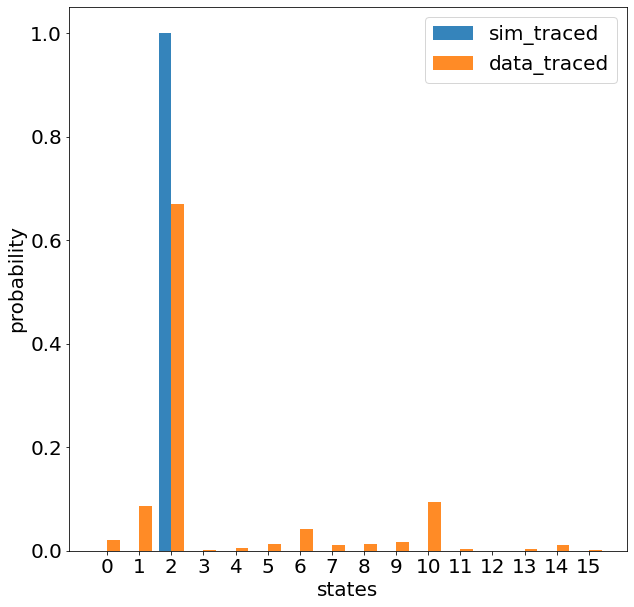

2023-07-11-203010_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



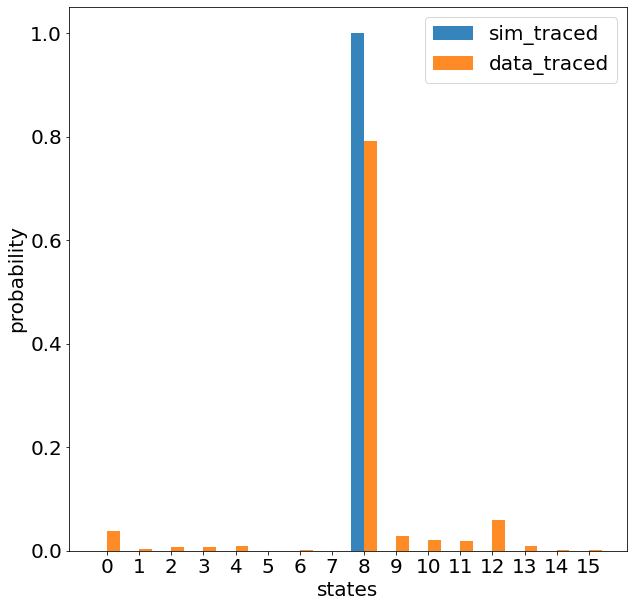

2023-07-11-203037_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



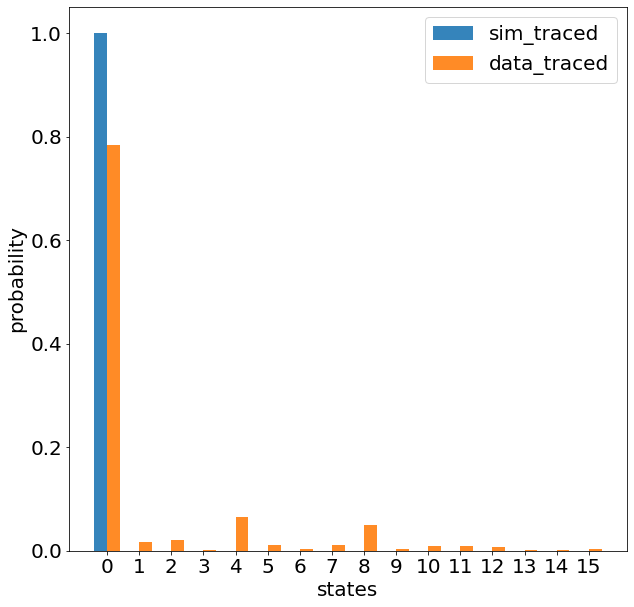

2023-07-11-203104_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



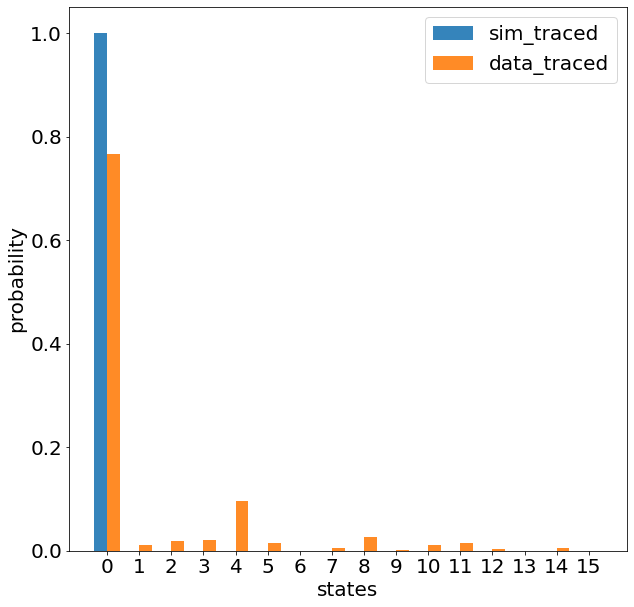

2023-07-11-203250_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



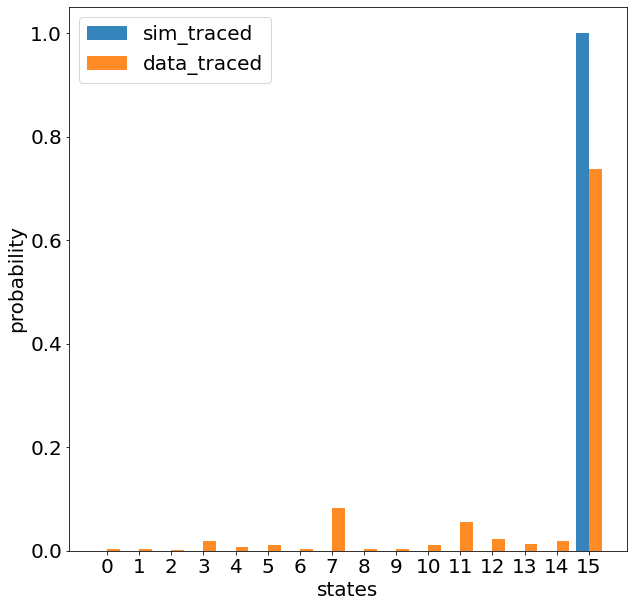

2023-07-11-203318_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



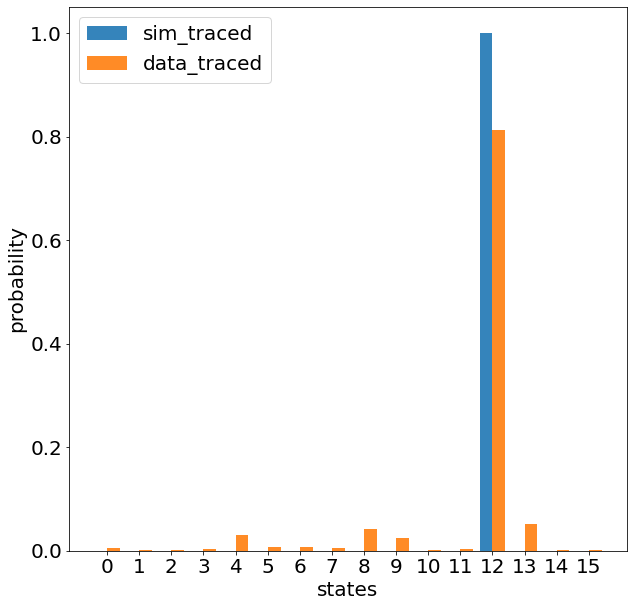

2023-07-11-203345_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



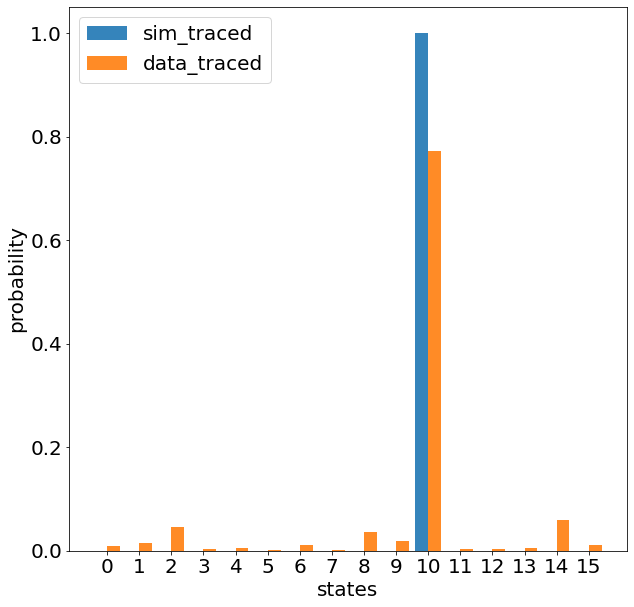

2023-07-11-233143_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



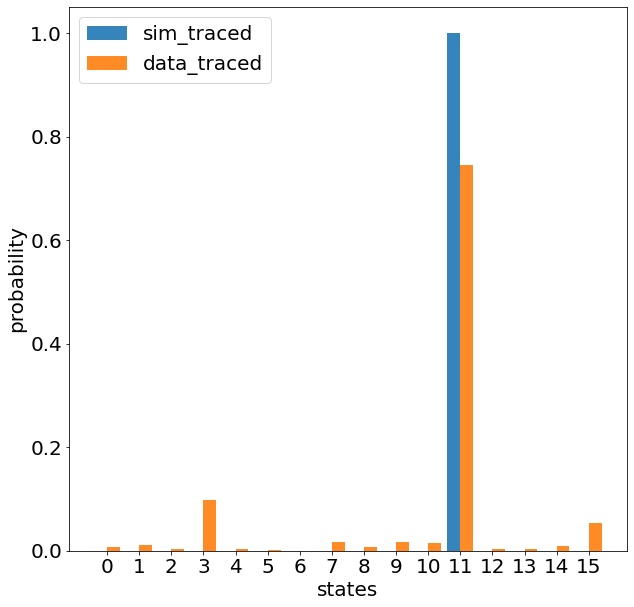

2023-07-11-233210_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



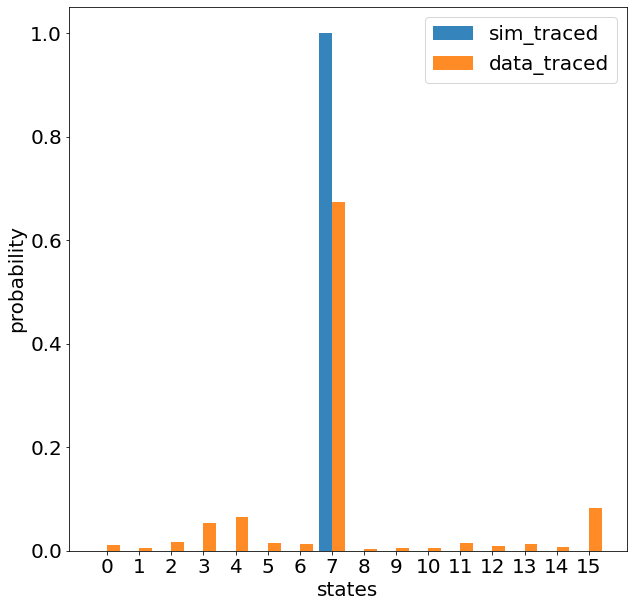

2023-07-11-233237_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



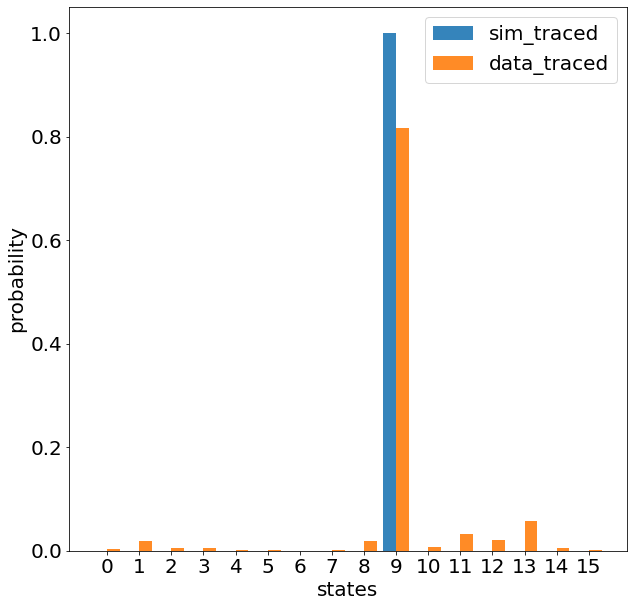

2023-07-11-233423_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



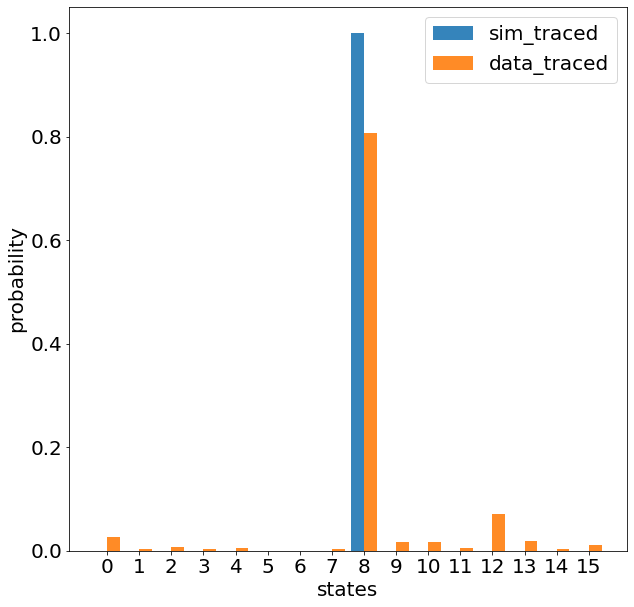

2023-07-11-233450_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



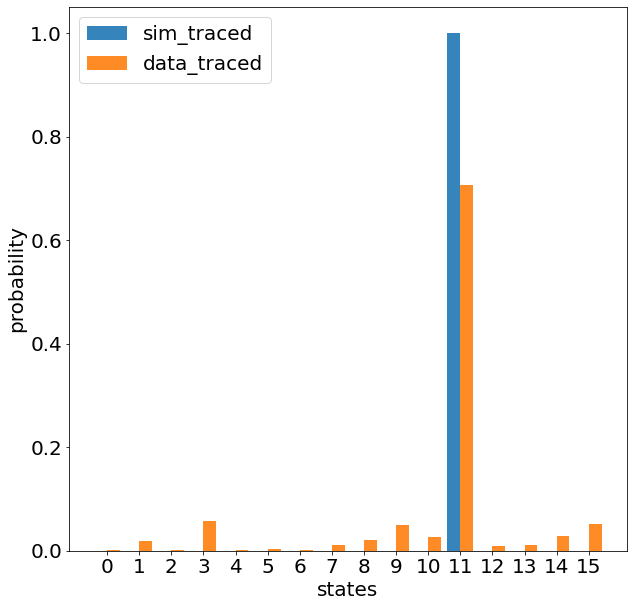

2023-07-11-233517_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



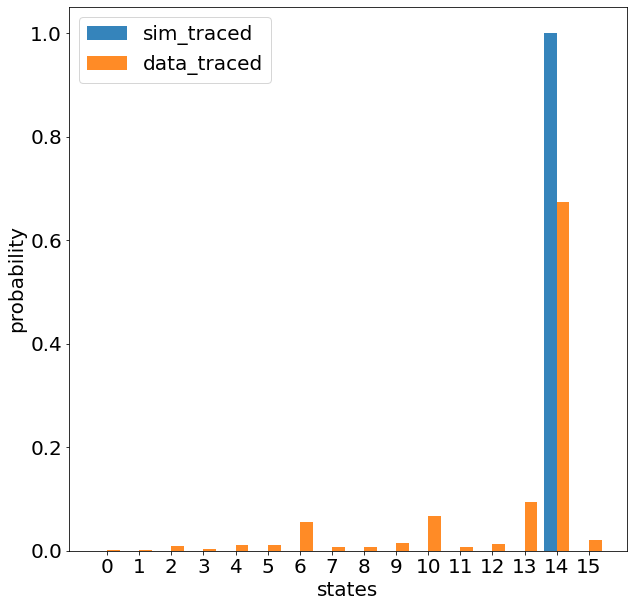

2023-07-12-000518_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



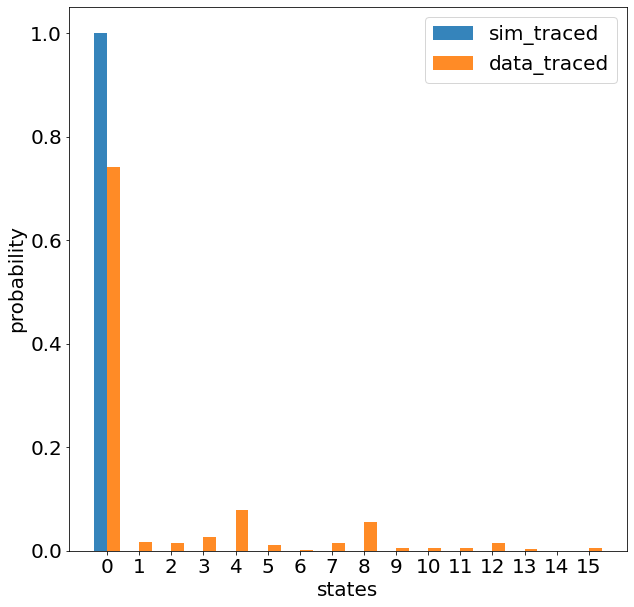

2023-07-12-000544_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



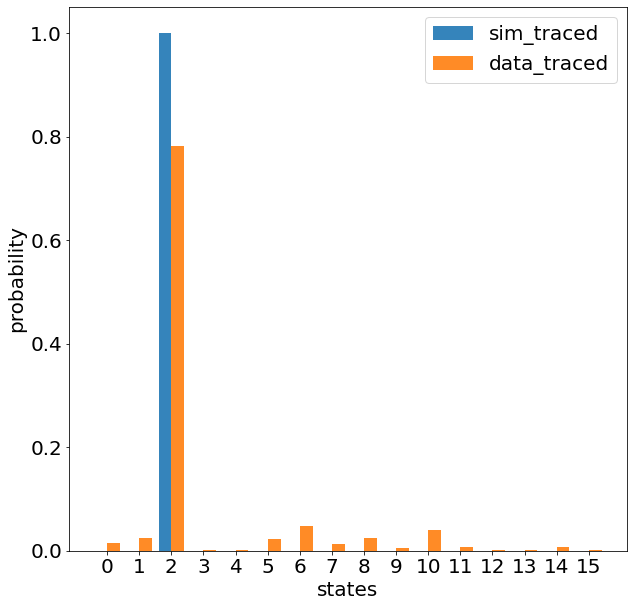

In [9]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
# print (len(filenames_data))
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    
    if (i<12):
        a_s=spam1.Correct_SPAM(a)
    else:
        a_s=spam2.Correct_SPAM(a)
        
    data_traced=Trace_Out(a_s,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)

#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d4_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d4_0703+filenames_d4_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])
# #         

2023-07-11-205835_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



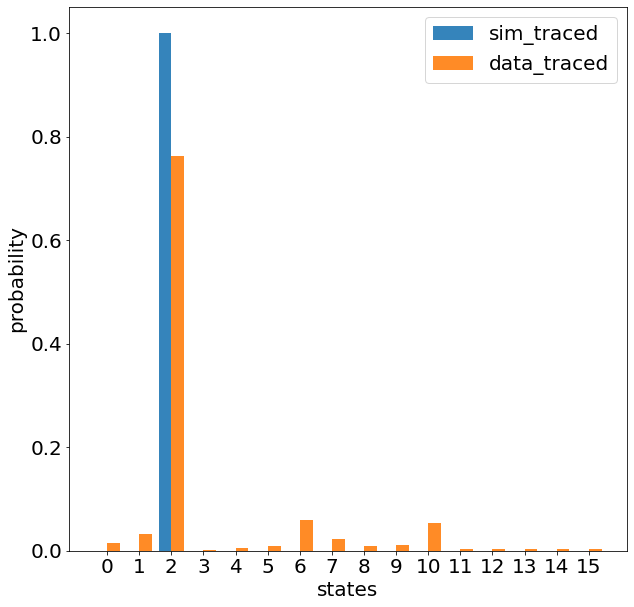

2023-07-11-205909_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



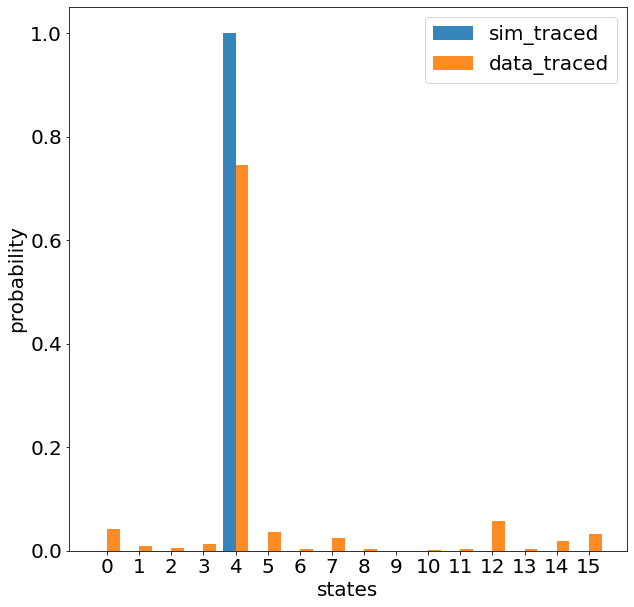

2023-07-11-210248_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



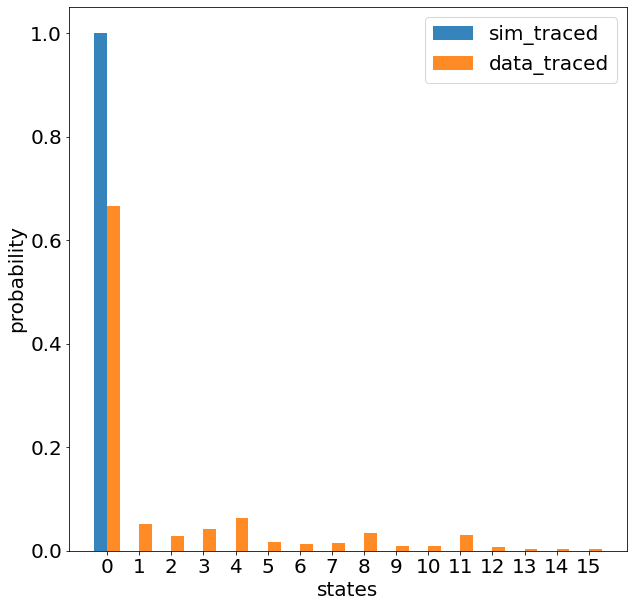

2023-07-11-210323_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



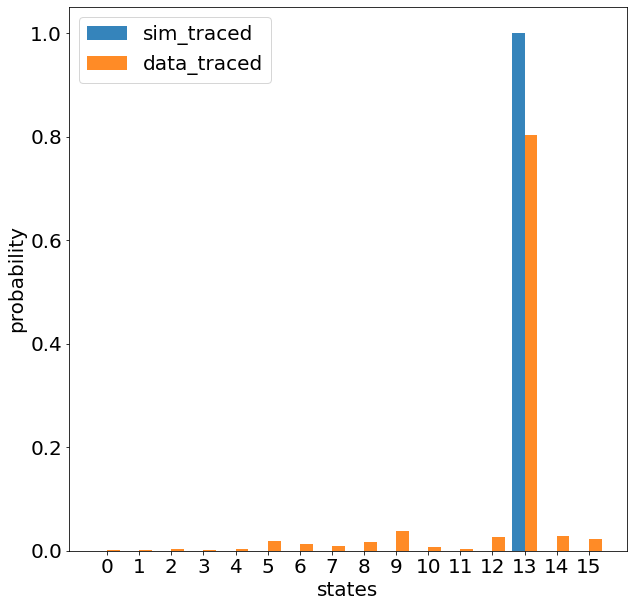

2023-07-11-210516_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



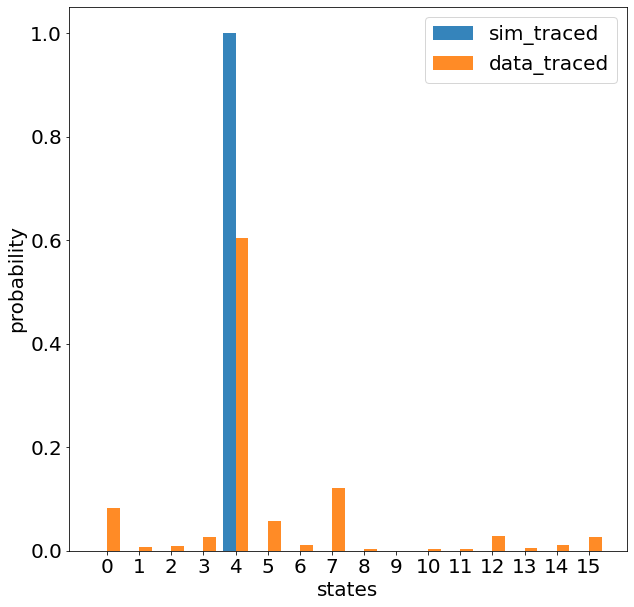

2023-07-11-210551_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



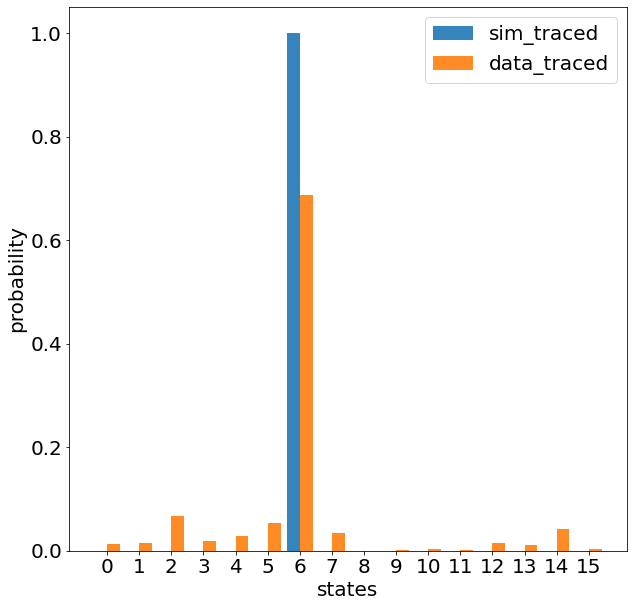

2023-07-11-210902_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



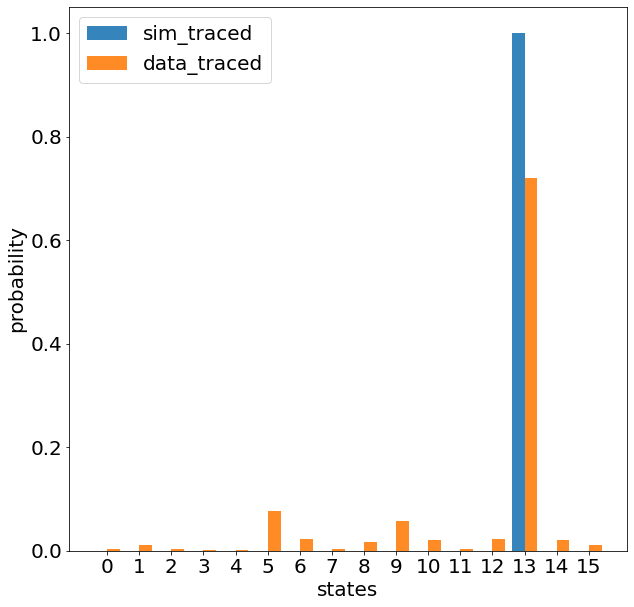

2023-07-11-210937_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



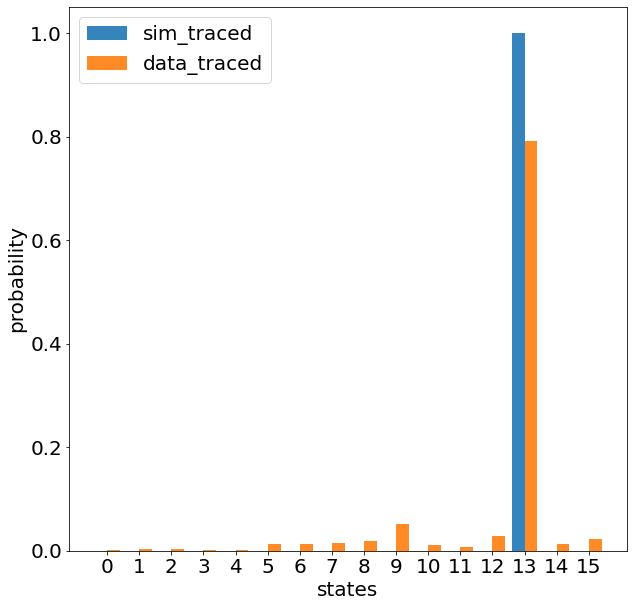

2023-07-11-211131_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



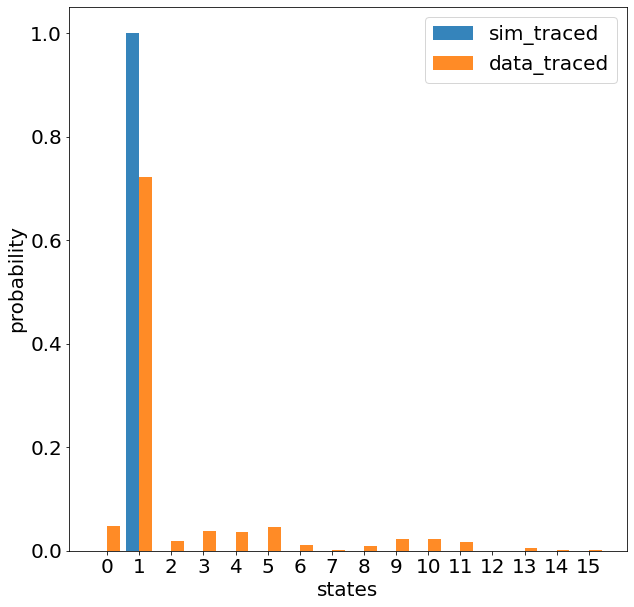

2023-07-11-211205_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



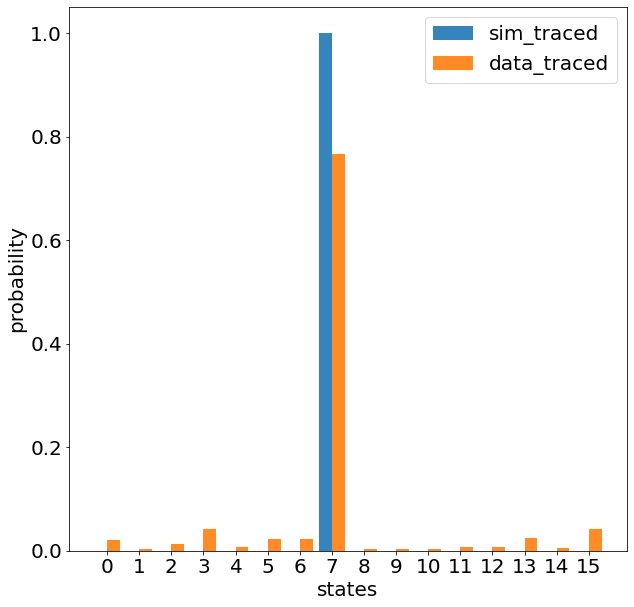

2023-07-12-001223_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



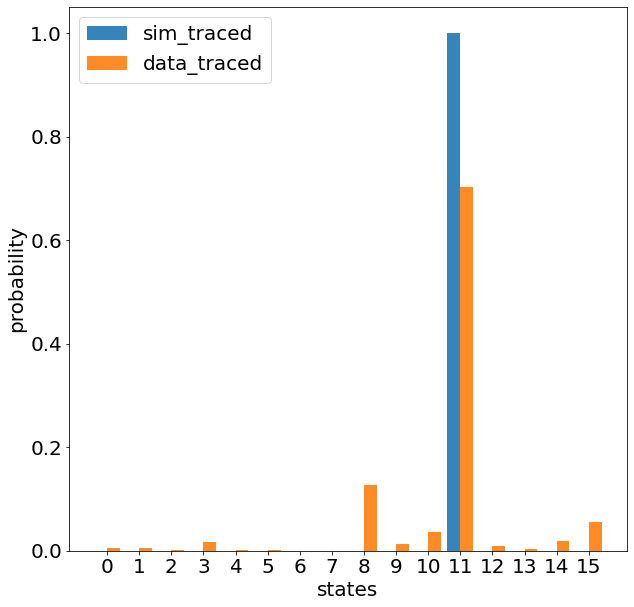

2023-07-12-001258_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



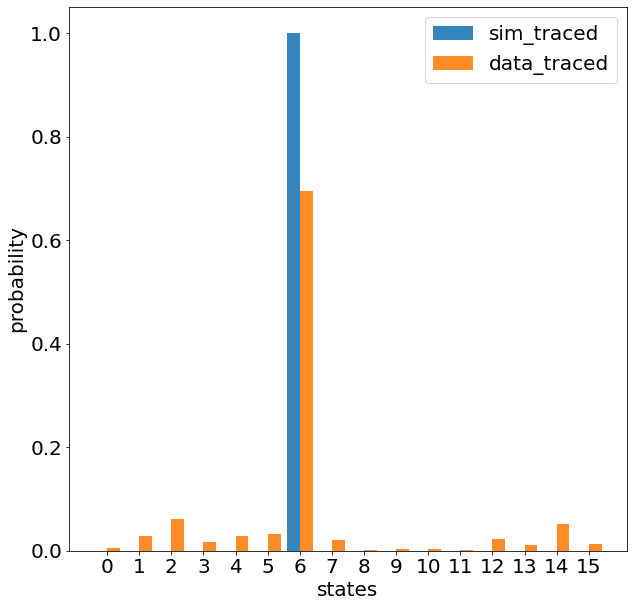

2023-07-12-001332_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



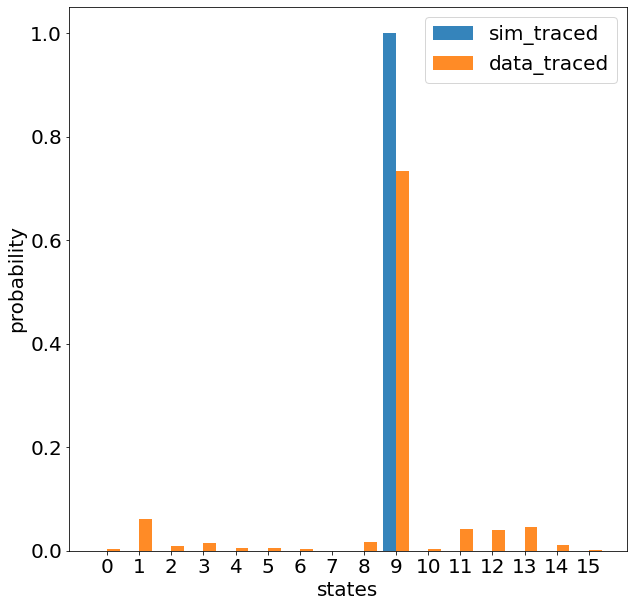

2023-07-12-001525_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



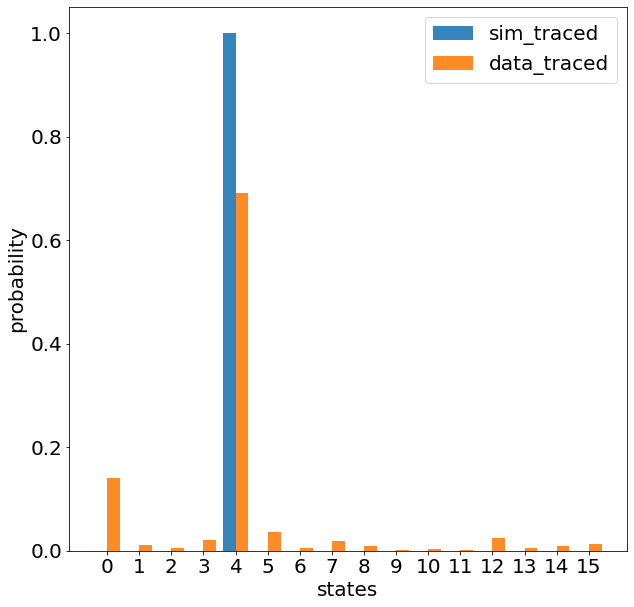

2023-07-12-001600_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



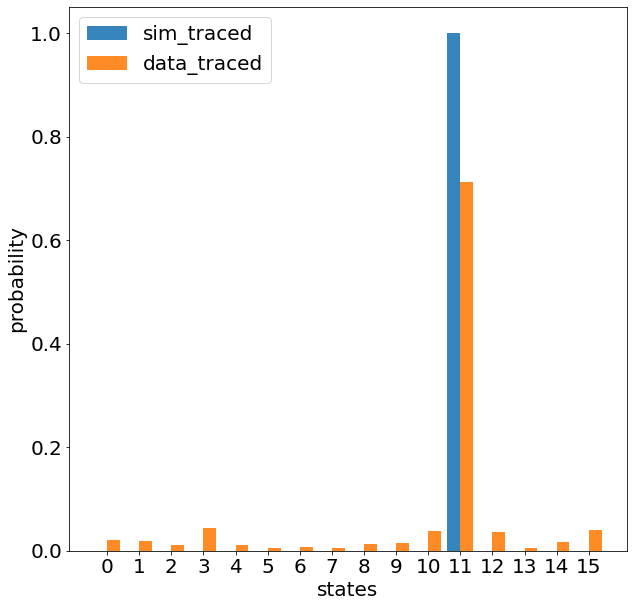

2023-07-12-001634_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



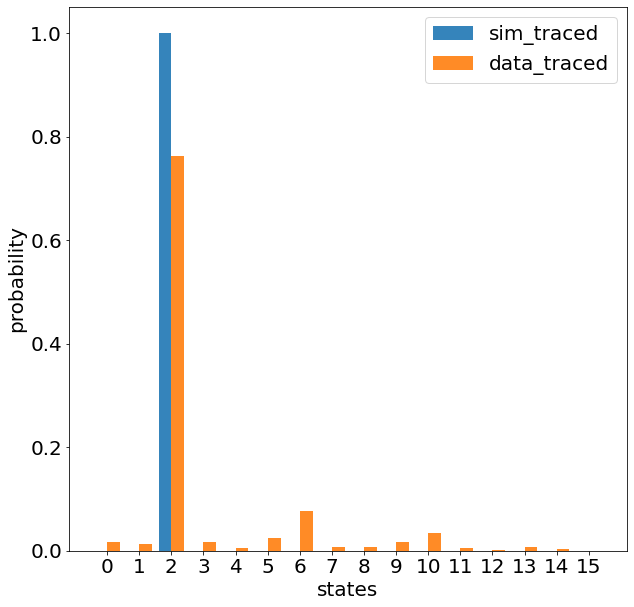

2023-07-12-001827_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



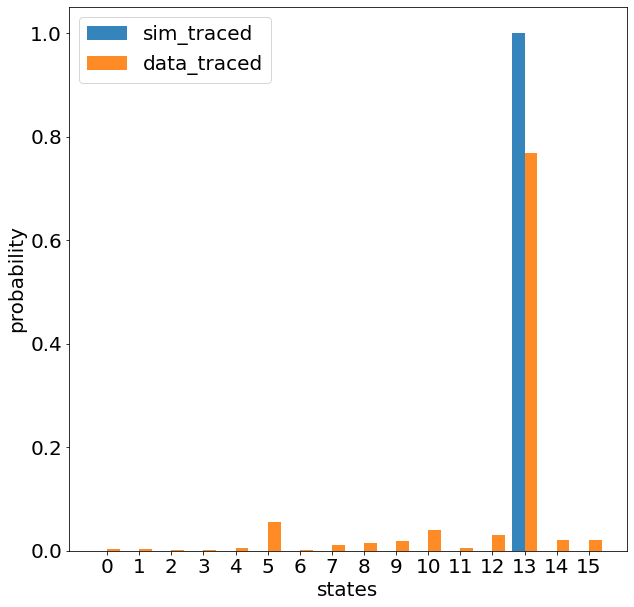

2023-07-12-001902_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



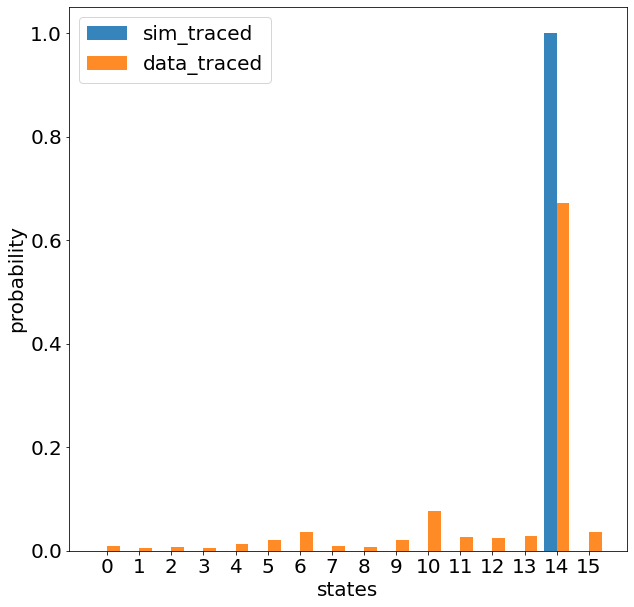

2023-07-12-001937_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



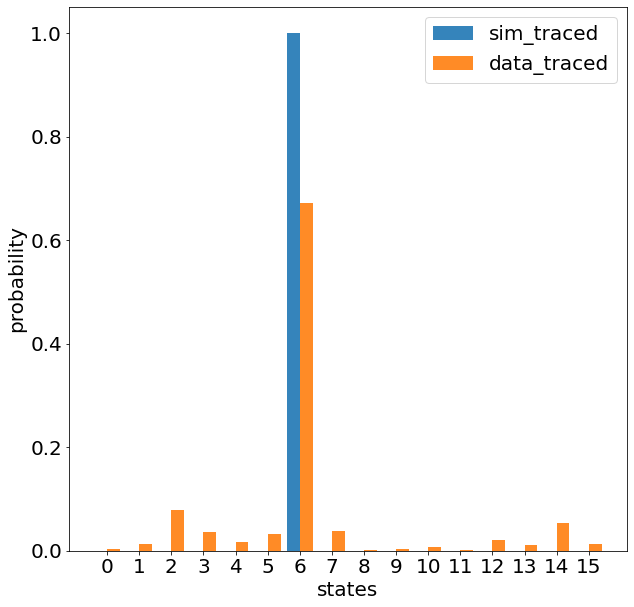

2023-07-12-002817_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



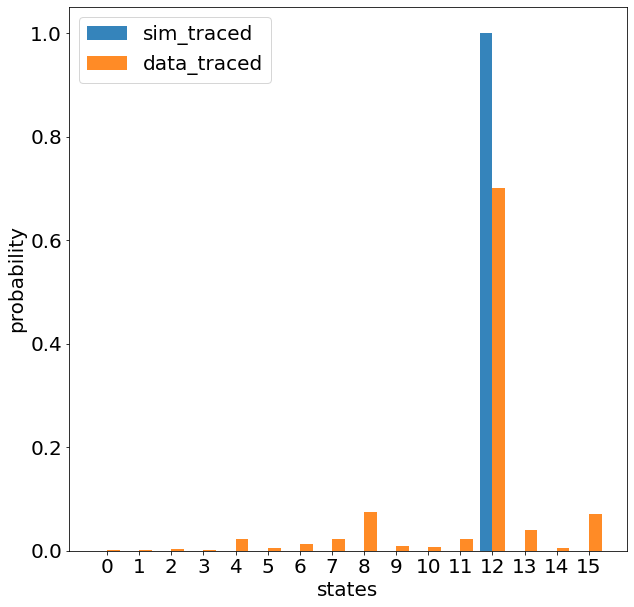

In [10]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    if (i<10):
        a_s=spam1.Correct_SPAM(a)
    else:
        a_s=spam2.Correct_SPAM(a)
    
    data_traced=Trace_Out(a_s,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

2023-07-11-221235_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



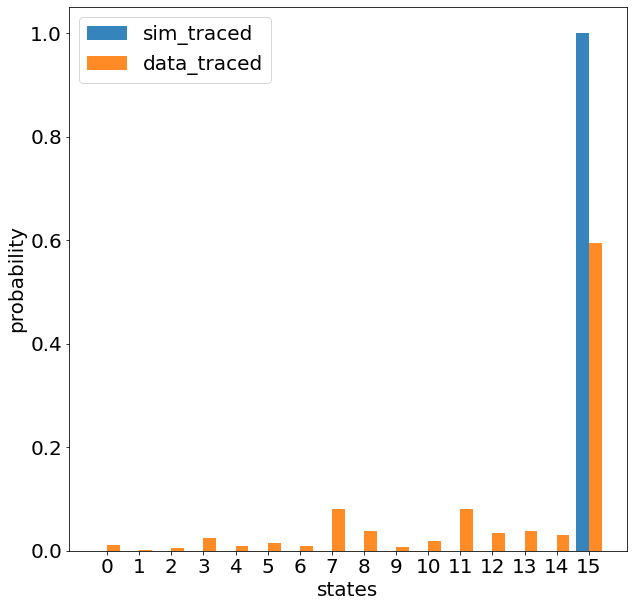

2023-07-11-221325_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



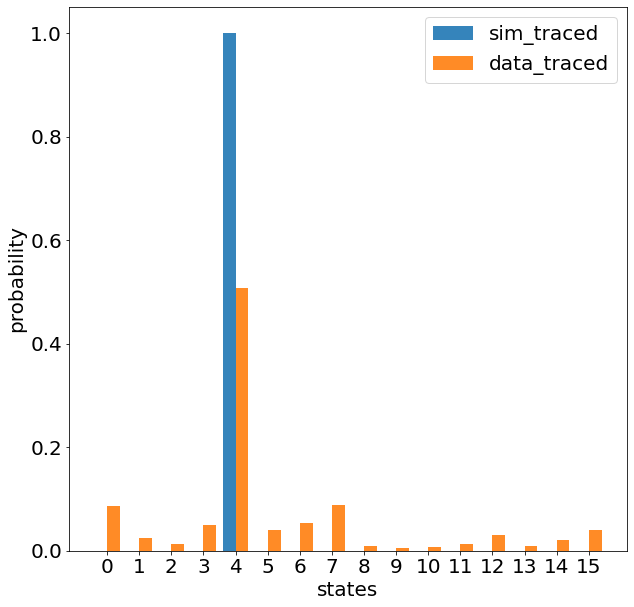

2023-07-11-221535_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



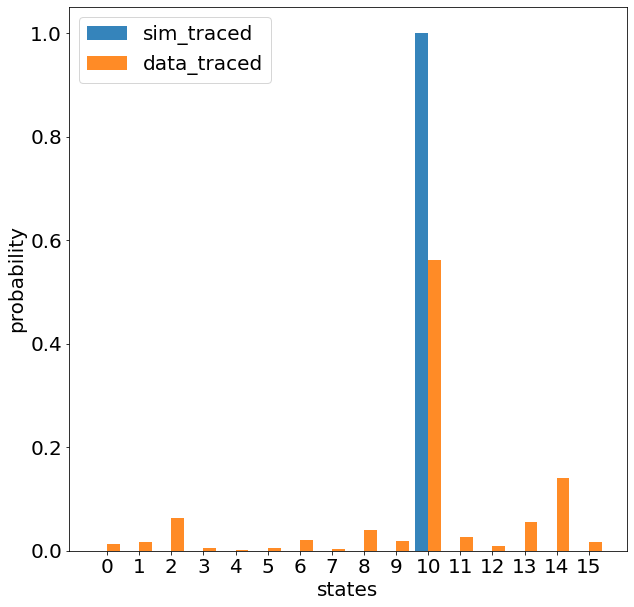

2023-07-11-221627_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



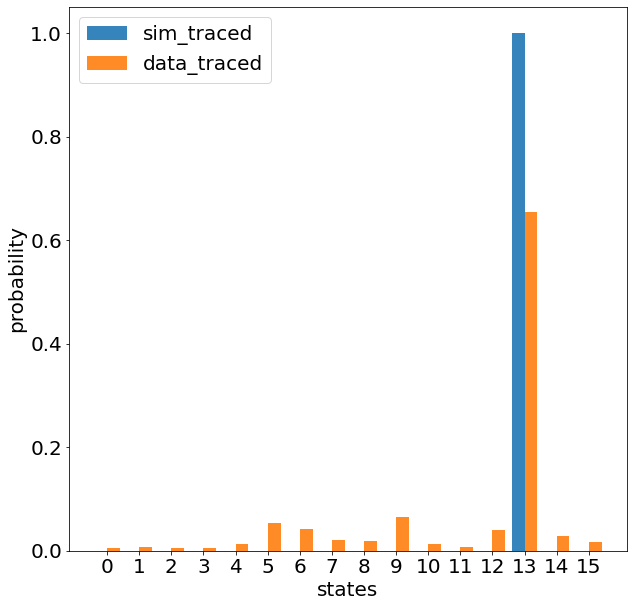

2023-07-11-221837_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



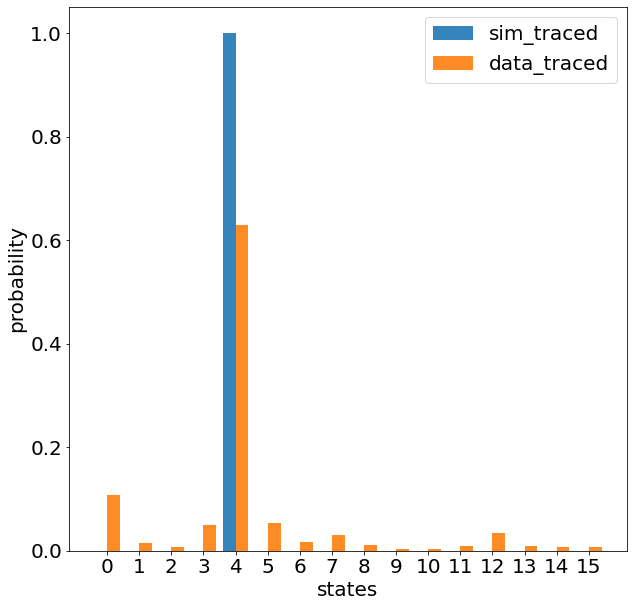

2023-07-11-221928_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



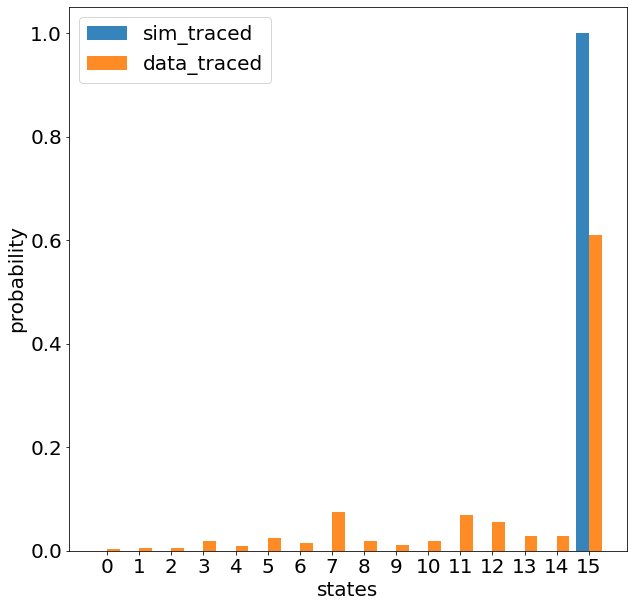

2023-07-11-222139_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



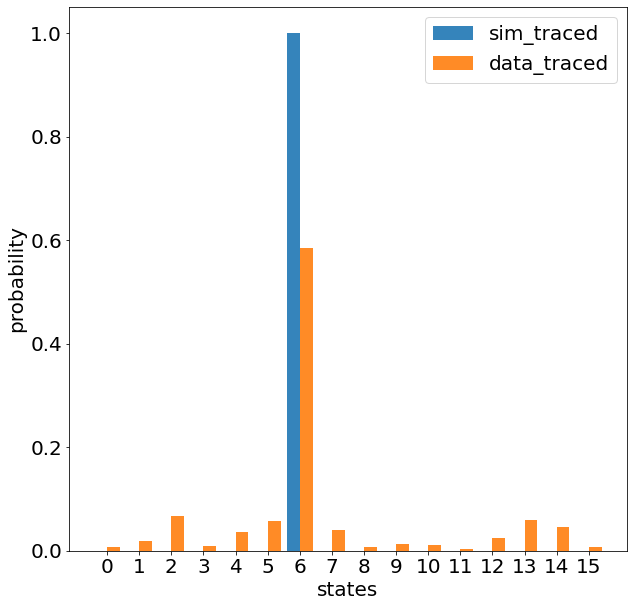

2023-07-11-222229_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



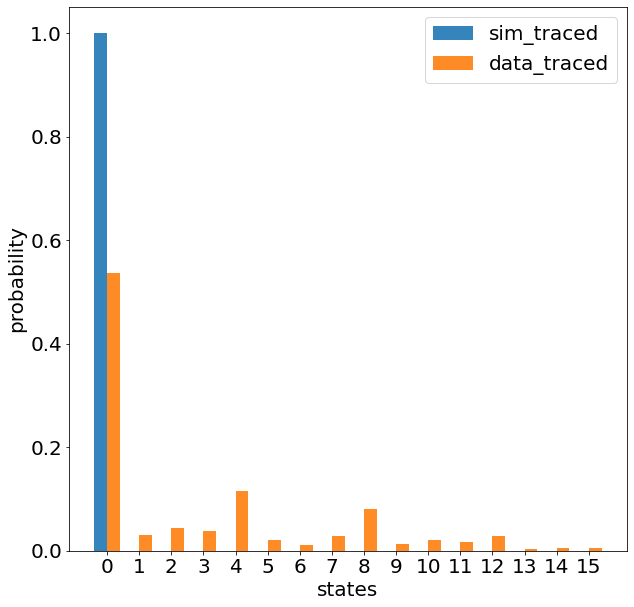

2023-07-11-222440_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



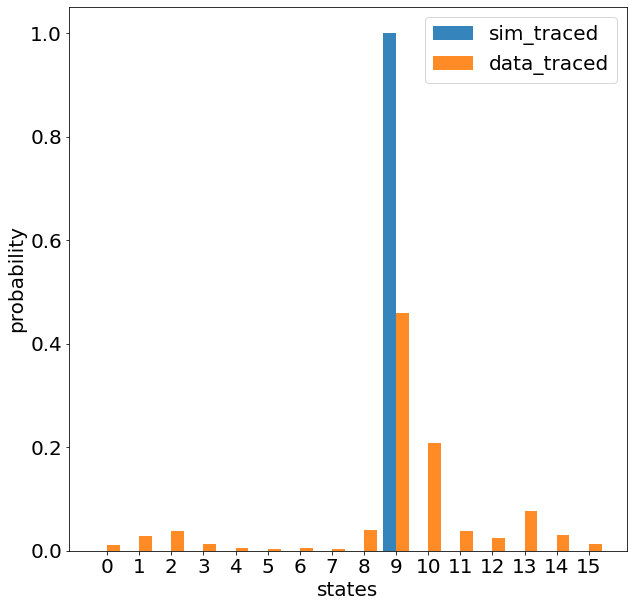

2023-07-11-222532_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



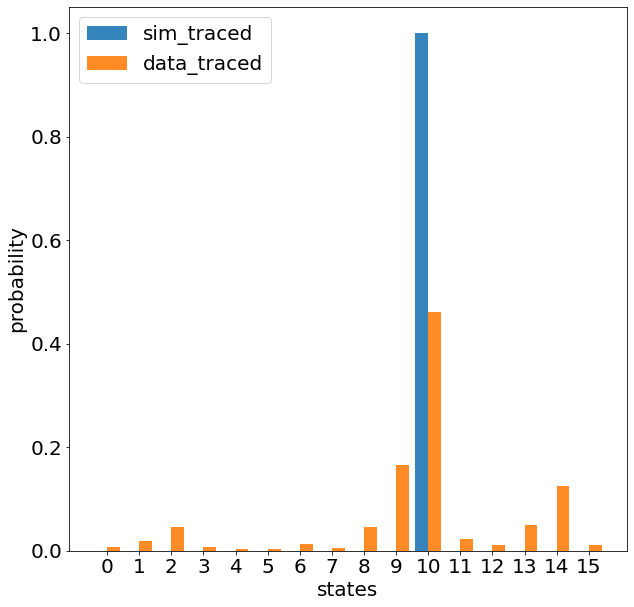

2023-07-12-003255_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



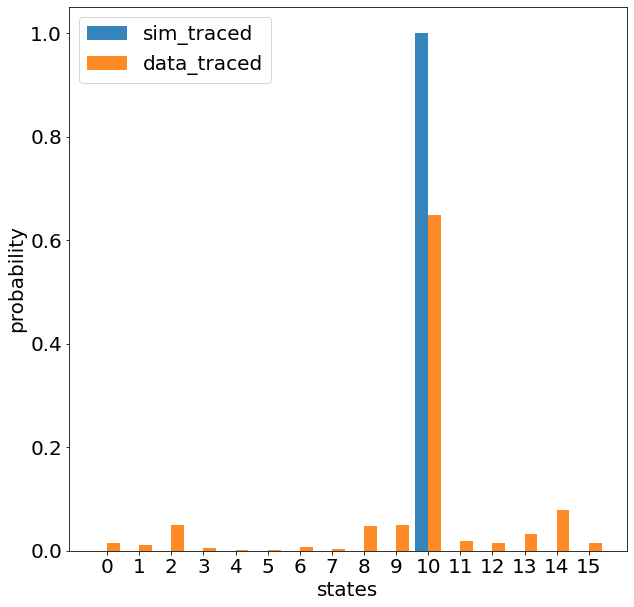

2023-07-12-003346_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



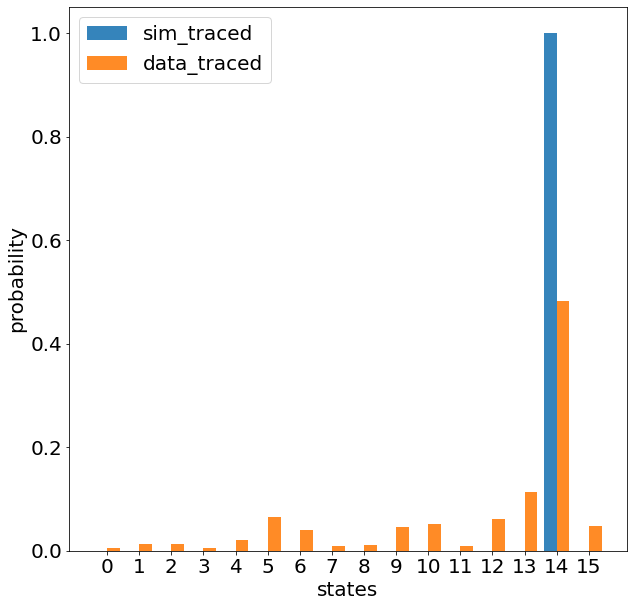

2023-07-12-003715_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



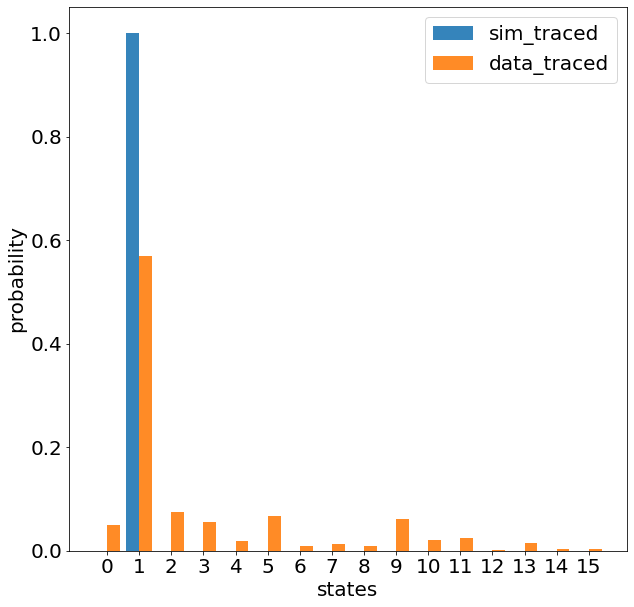

2023-07-12-003805_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



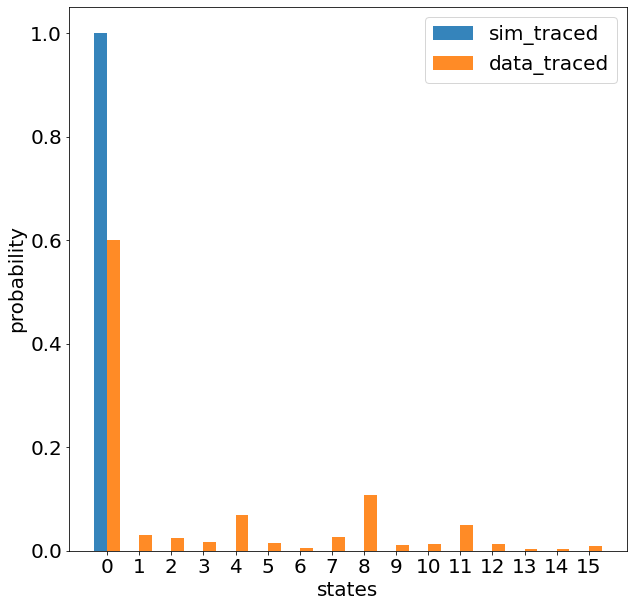

2023-07-12-004014_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



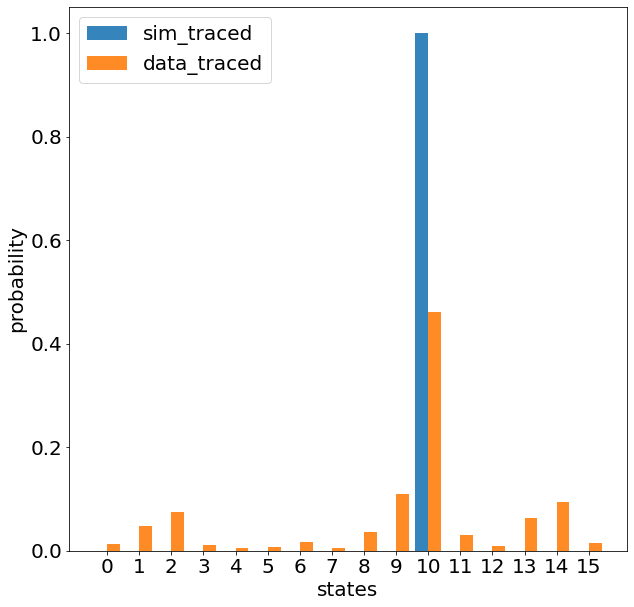

2023-07-12-004105_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



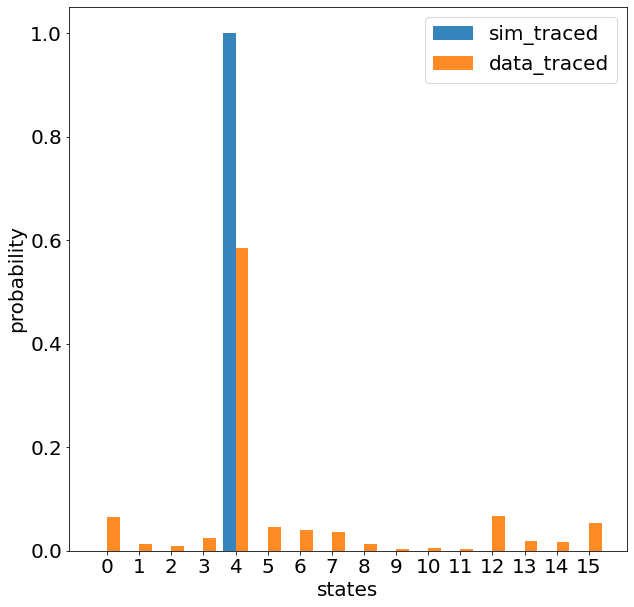

2023-07-12-004315_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



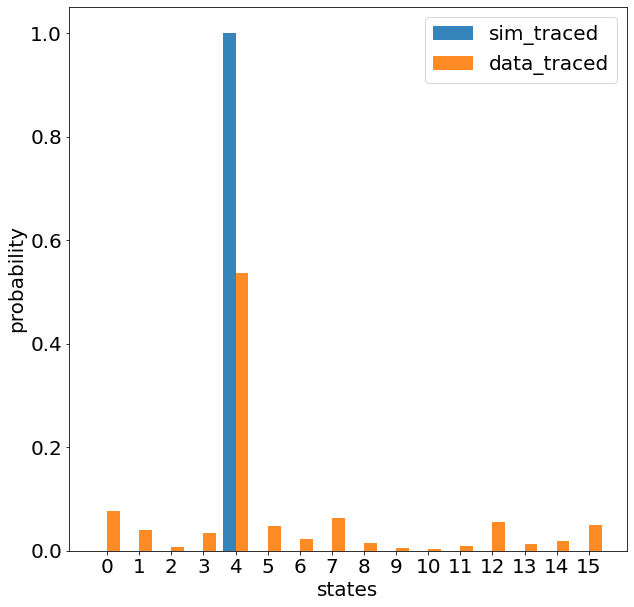

2023-07-12-004405_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



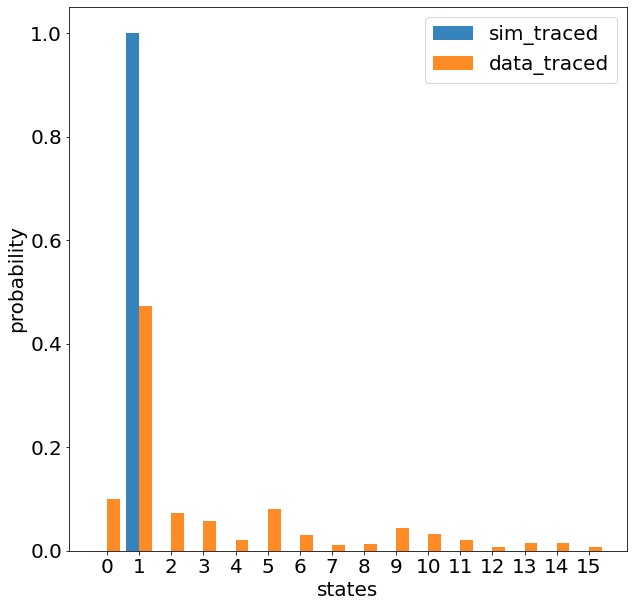

2023-07-12-004615_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



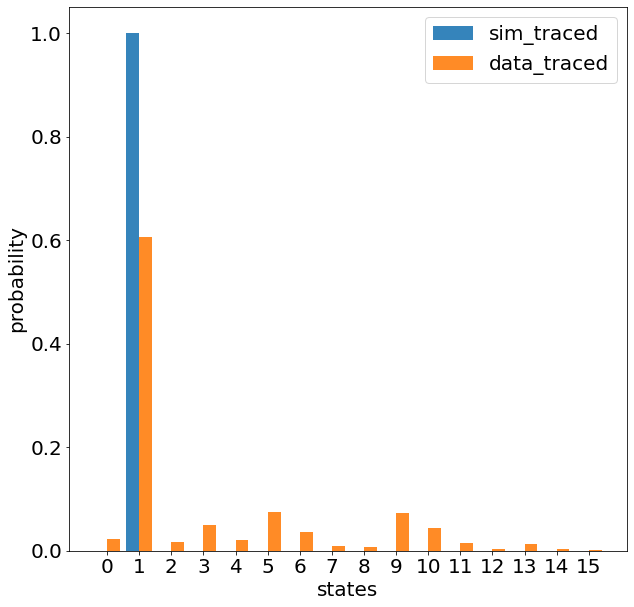

2023-07-12-004706_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



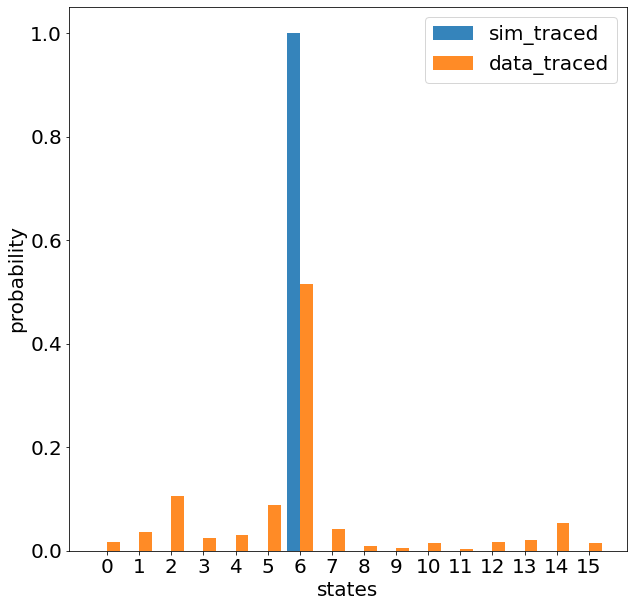

In [11]:
filenames_data=[]
counts_d16=[]
counts_d16_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d16.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d16
circuit=c_d16
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)

    a_s=spam2.Correct_SPAM(a)
    
    data_traced=Trace_Out(a_s,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d16.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

2023-07-11-223610_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:

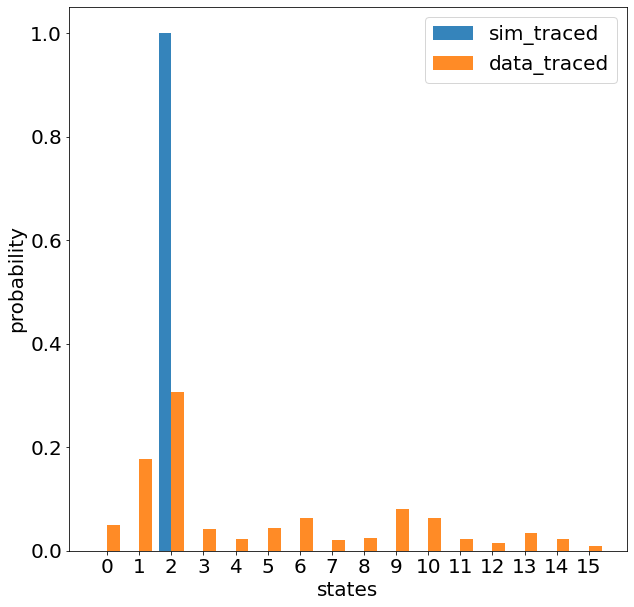

2023-07-11-223739_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3


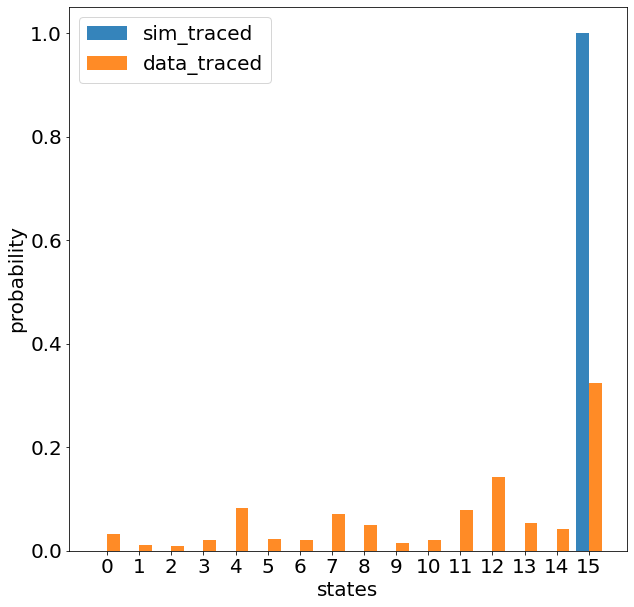

2023-07-11-224029_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



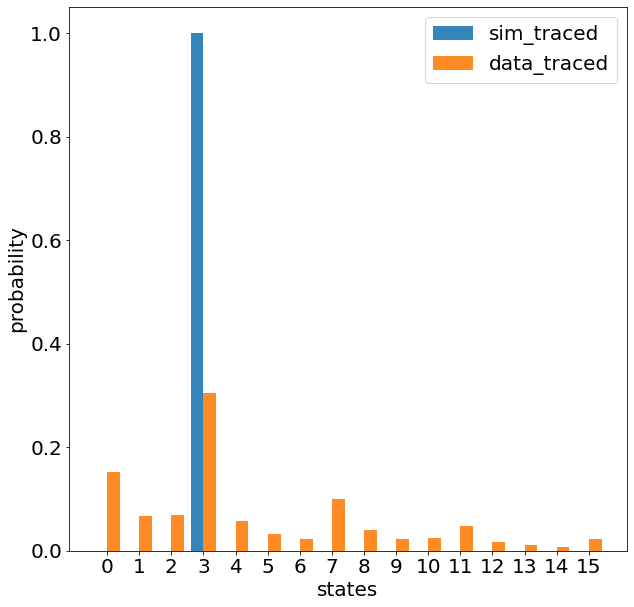

2023-07-11-224201_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:A

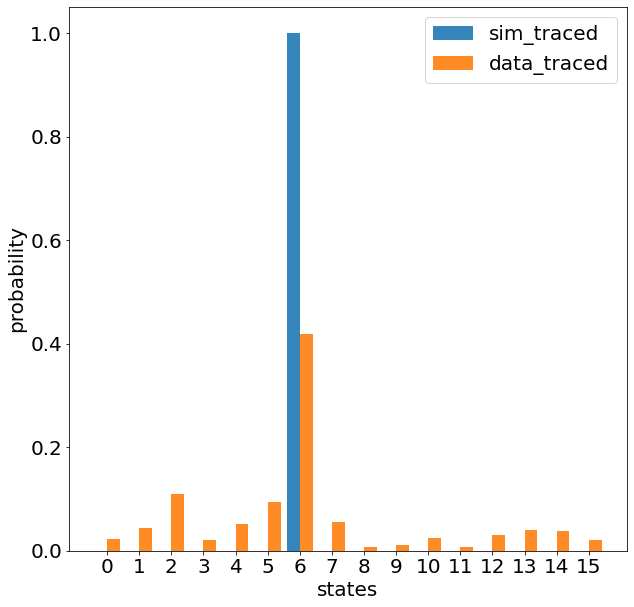

2023-07-11-224451_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



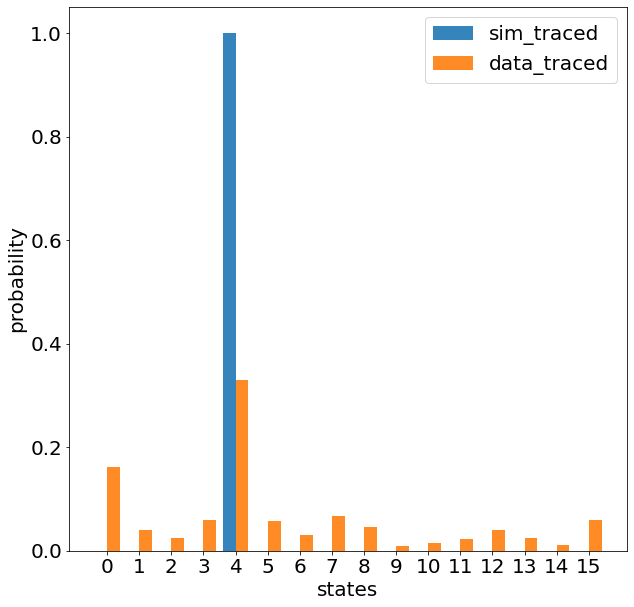

2023-07-11-224622_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:R

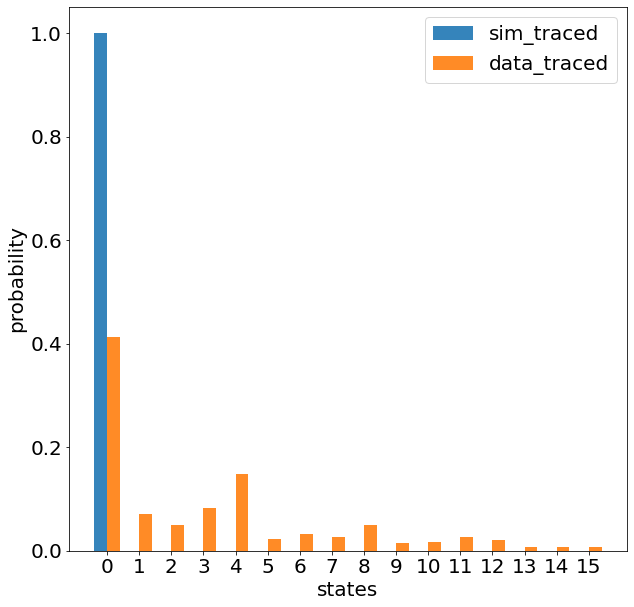

2023-07-12-005144_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



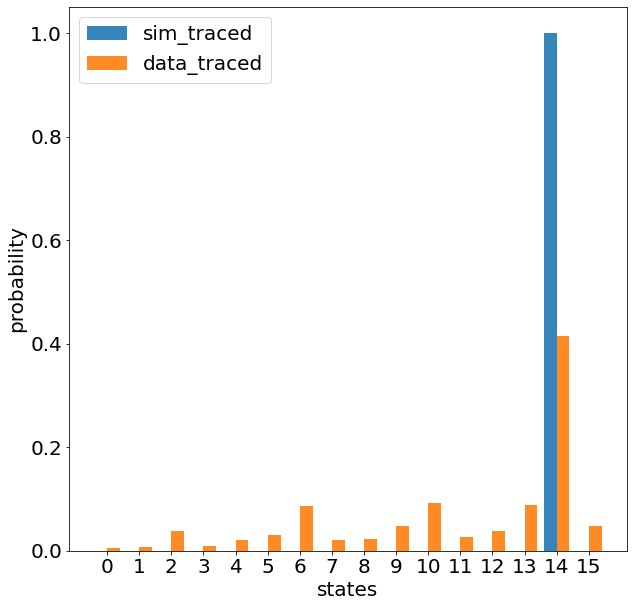

2023-07-12-005315_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32

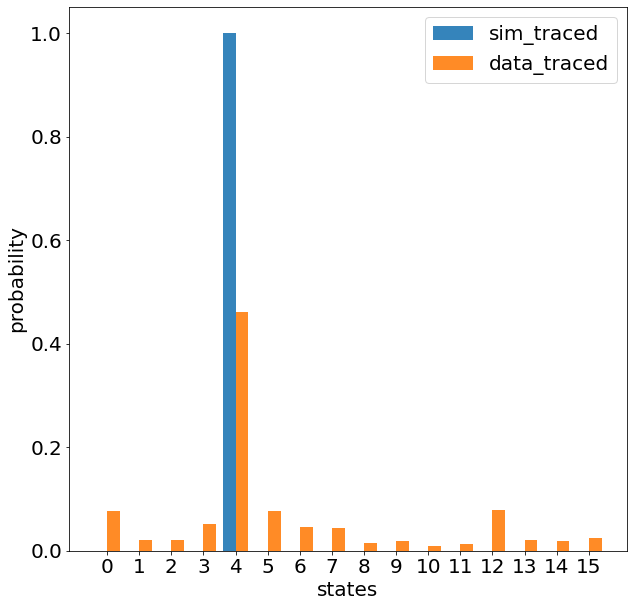

2023-07-12-005446_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



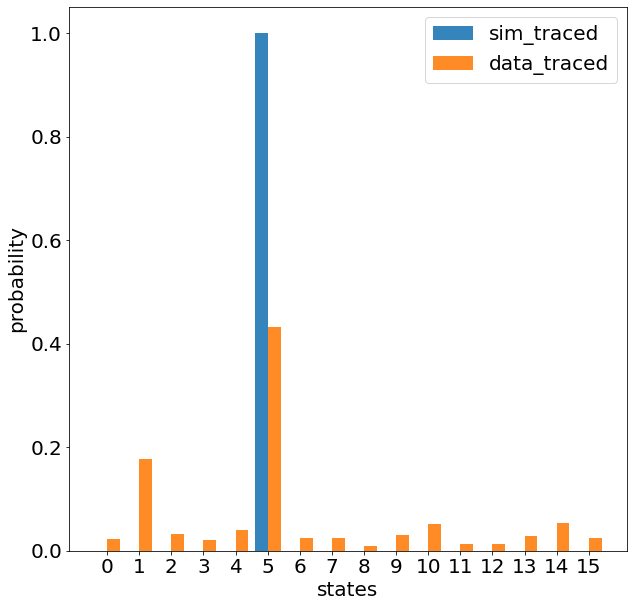

2023-07-12-005736_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



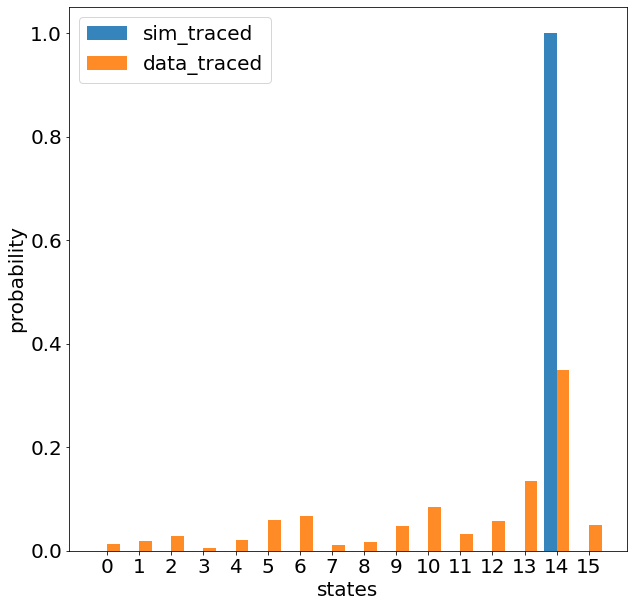

2023-07-12-005905_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



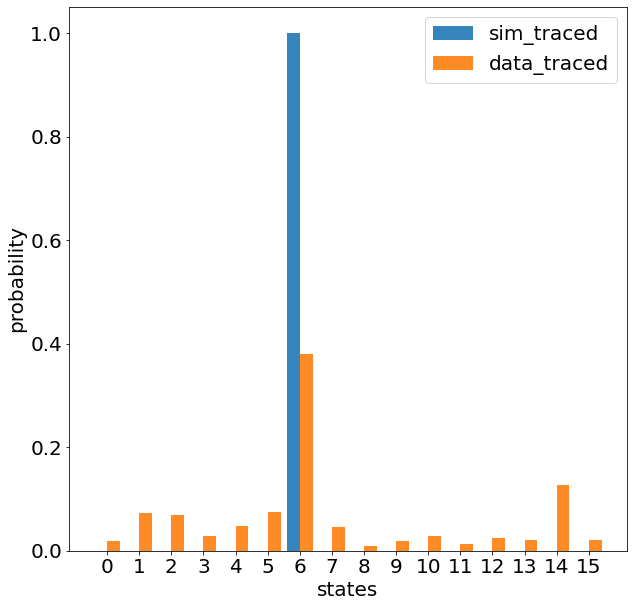

2023-07-12-010035_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD

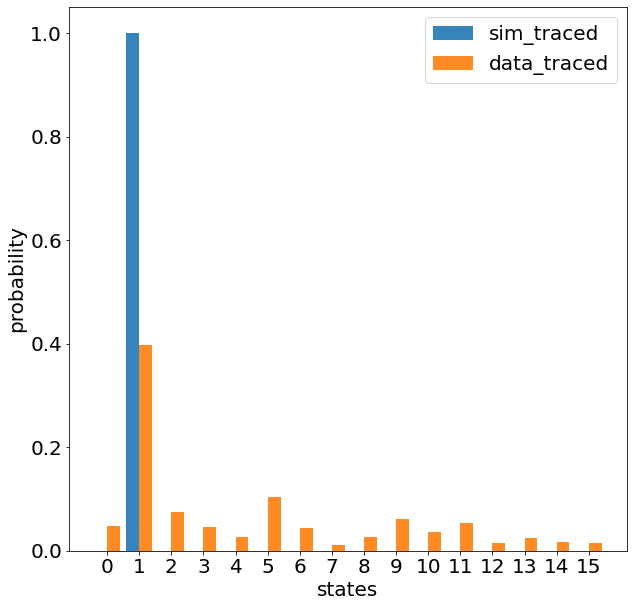

2023-07-12-010321_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



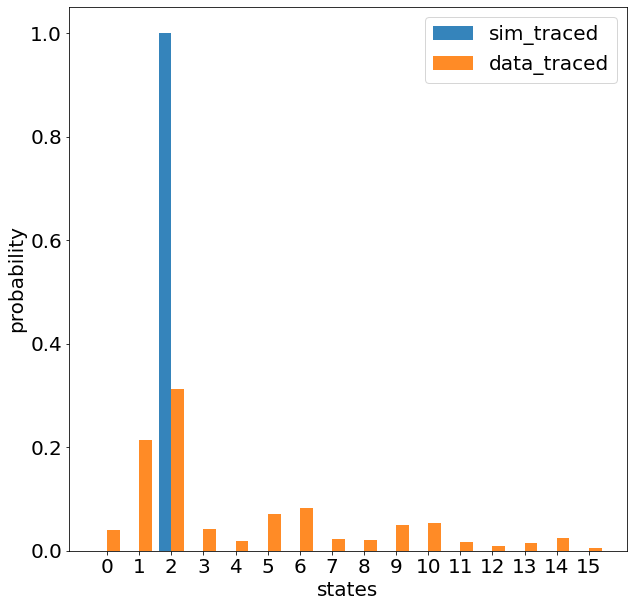

2023-07-12-010454_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RY+21:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:H

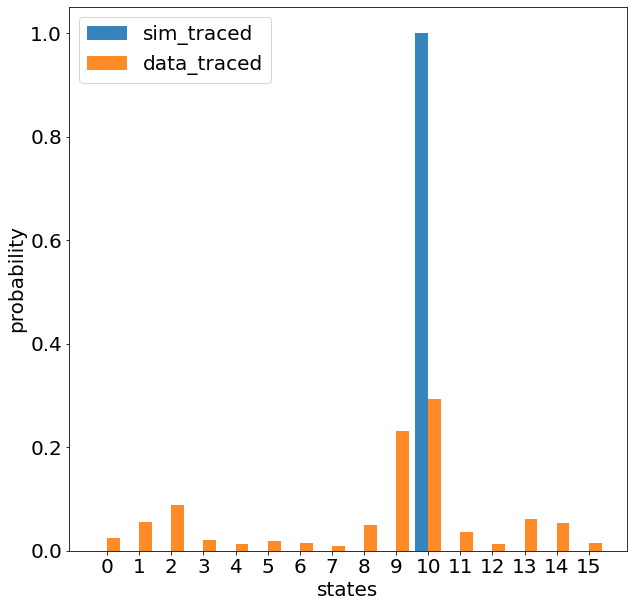

2023-07-12-010627_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD

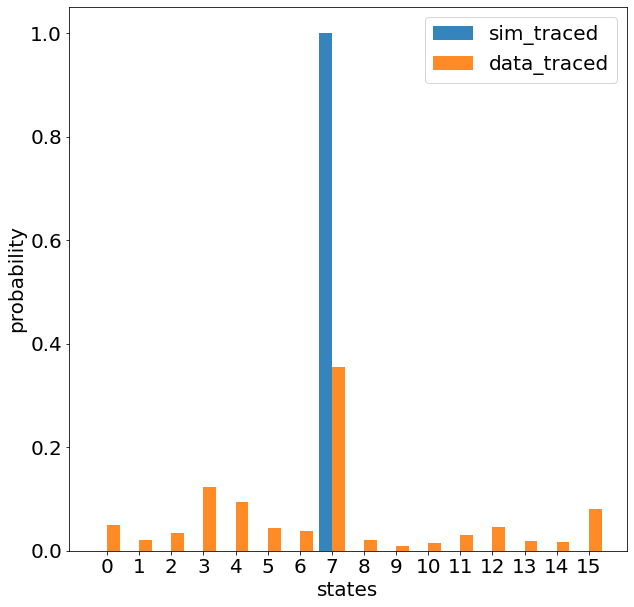

2023-07-12-013746_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RY+31:XA230.2500+:XA230.2500+:RX+21:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:RY+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



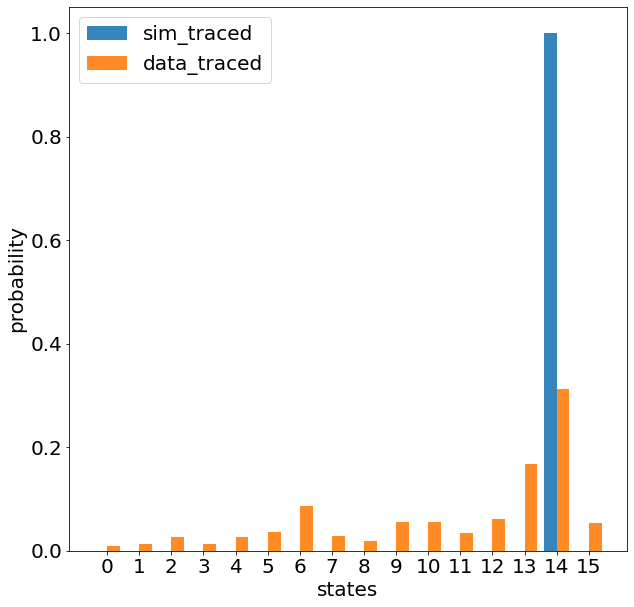

2023-07-12-013916_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:XA230.2500+:RX+21:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



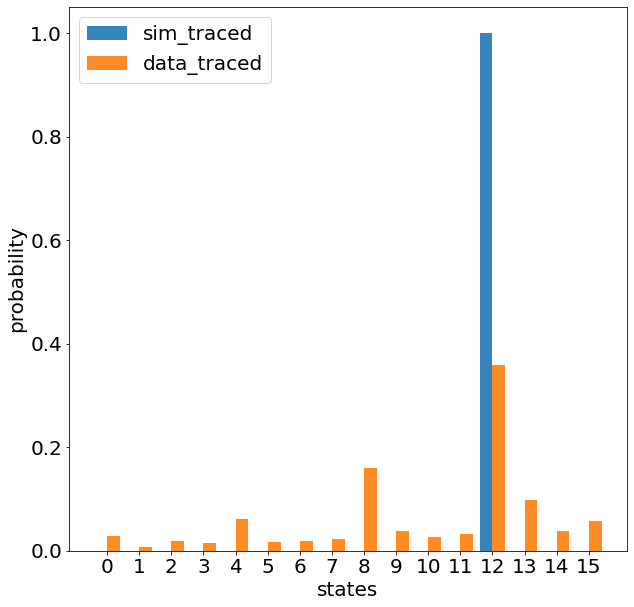

2023-07-12-014046_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:

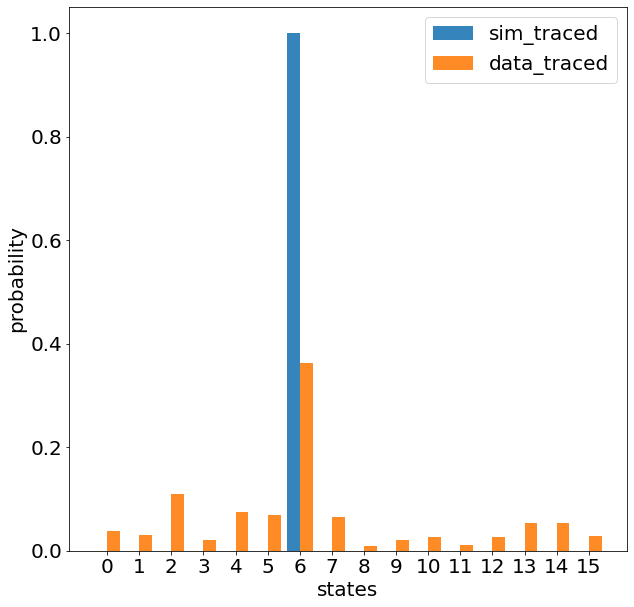

2023-07-12-015900_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:XA230.2500+:RX+21:XA230.2500+:RX+31:XA230.2500+:RY+31:XA230.2500+:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:AZ3+1.0000:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RX+31:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



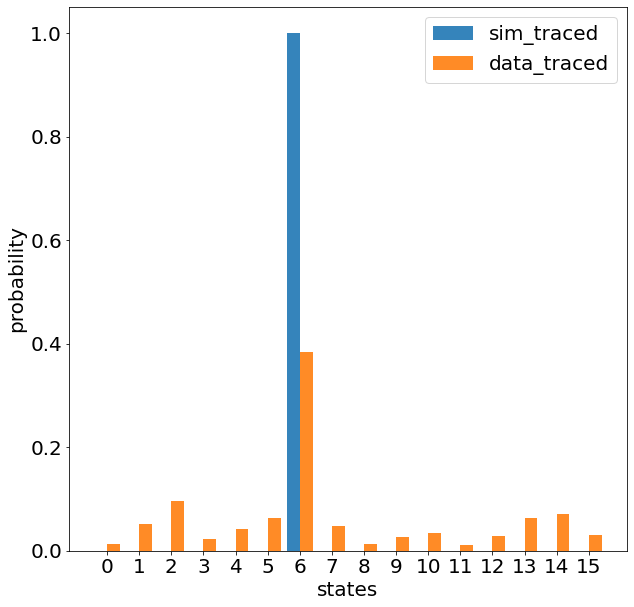

2023-07-12-020031_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+21:XA230.2500+:AZ2+1.0000:XA230.2500+:RY+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ3+1.0000:XA230.2500+:RX+21:RY+31:XA230.2500+:AZ2+1.0000:AZ3+1.0000:XA230.2500+:RX+31:XA230.2500+:XA230.2500+:RX+21:RX+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:AZ2+1.0000:RX+31:XA230.2500+:RY+21:RY+31:XA230.2500+:RX+21:XA230.2500+:RY+21:XA230.2500+:RY+21:XA230.2500+:AZ3+1.0000:XA230.2500+:RY+21:RX+31:XA230.2500+:RY+31:XA230.2500+:RY+21:AZ3+1.0000:XA230.2500+:RY+31:XA230.2500+:RY+21:RX+31:XA230.2500+:RX+31:XA230.2500+:RY+21:RX+31:XA230.2500+:AZ2+1.0000:XA230.2500+:AZ2+1.0000:AZ3+1.0000:RY+22:XA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:XA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



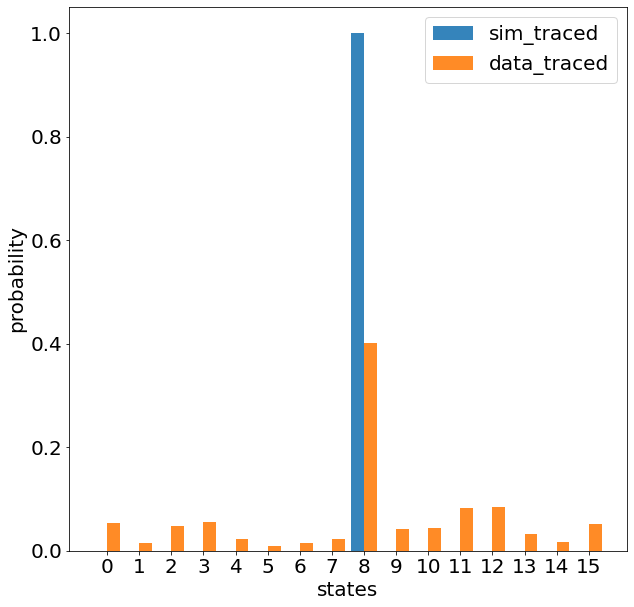

In [12]:
filenames_data=[]
counts_d32=[]
counts_d32_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d32.copy()
# print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d32
circuit=c_d32
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    a_s=spam2.Correct_SPAM(a)
    data_traced=Trace_Out(a_s,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d32.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

In [13]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [14]:
import copy
from copy import copy, deepcopy
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/XX23541_noSE_explicitCNOT_FT_R0627_01+10/5842626d-f518-4838-a0a2-c93e640ed4ffXX23541_noSE_explicitCNOT_FT_R0627_01+10", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)

eab_load_cpy=deepcopy(eab_load[0:100])
eab_load_cpy_spam=deepcopy(eab_load[0:100])

In [15]:
C=20
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    print (eab_load_cpy[i]["counts"])
    print (counts_d2_sim[i])

    print (counts_d2[i].copy())
    print ("\n")
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 1, '1000': 25, '0100': 70, '1100': 1603, '0010': 3, '1010': 6, '0110': 36, '1110': 92, '0001': 2, '1001': 30, '0101': 6, '1101': 100, '0011': 1, '1011': 9, '0111': 7, '1111': 10}


{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 143, '1000': 30, '0100': 4, '1100': 9, '0010': 1618, '1010': 90, '0110': 1, '1110

IndexError: list index out of range

In [ ]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==4
#     eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()

    #     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (C,2*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [ ]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

# for i in range (2*C,3*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==8
#     eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()

#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (2*C,3*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [ ]:
# print (eab_load_cpy)

In [ ]:
for i in range (3*C,4*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==16
    eab_load_cpy[i]["counts"]=counts_d16[i-3*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (4*C,5*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==32
    eab_load_cpy[i]["counts"]=counts_d32[i-4*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

In [ ]:
filename = str(uuid.uuid4())
filename+="XX23541_noSE_explicitCNOT_XX_R_0711_01+10_ExperimentalData_SPAM"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/eab_results_file/"+filename, "wb") as fp:
    pickle.dump(eab_load_cpy, fp)


In [ ]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
C=20
nqubit=2
depth=[2,4,8,16,32]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB_01(depth, eab_load_cpy, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


Data analysis

In [ ]:
raw_fidelity_list = eab_result["fidelity_list"]

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = fit_EAB_depth1(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_2={}
plot_2=deepcopy(plot_dic)
err_2=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_24={}
plot_24=deepcopy(plot_dic)
err_24=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)


In [ ]:
def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

    print(alpha, alpha_err)



plot average fidelity and fit

In [ ]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

plot fidelity from each circuit and fit

In [ ]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(8, 2)
fig.set_figwidth(20)
fig.set_figheight(100)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (8):
    for j in range(2):
        pauli_label=pauli_request_list[2*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
#             axs[i, j].plot([2],[tuple(eab_result['fidelity_list'][pauli_label][2])],"*",markersize=3)
#             axs[i, j].plot([4],[tuple(eab_result['fidelity_list'][pauli_label][4])],"*",markersize=3)
#             axs[i, j].plot([8],[tuple(eab_result['fidelity_list'][pauli_label][8])],"*",markersize=3)
#             axs[i, j].plot([16],[tuple(eab_result['fidelity_list'][pauli_label][16])],"*",markersize=3)
#             axs[i, j].plot([32],[tuple(eab_result['fidelity_list'][pauli_label][32])],"*",markersize=3)
            axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=8)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

data analysis with bootstrapping

In [ ]:
import bootstrap

raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
alpha_detail={}
a_detail={}
alpha_error_detail={}
Y_detail={}
Y_err_detail={}
# a248_dic={}
# Y248_dic={}
# Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        fidelity_list[pauli_label] = alpha_bootstrap #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
#         a248_dic[pauli_label]=a 
#         Y248_dic[pauli_label]=Y
#         Yerr248_dic[pauli_label]=Yerr
        alpha_detail[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
        Y_detail[pauli_label]=Y_rtn_frm_fit
        Y_err_detail[pauli_label]=Yerr_rtn_frm_fit

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label,1-fidelity_list[pauli_label],stdev_list[pauli_label])

#         print (alpha_detail[pauli_label])


In [ ]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


In [ ]:
print (type(raw_fidelity_list[pauli_label][2]))
print (raw_fidelity_list[pauli_label])

spam results

In [ ]:
print (eab_load)

In [ ]:
print (type(eab_result["fidelity_list"]["IX"][2]))

In [ ]:
print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
y2=[tuple(eab_result['fidelity_list'][pauli_label][2])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = [(1,1,2,4)]
x = [2]
plt.plot(x,[tuple(eab_result['fidelity_list'][pauli_label][2])],"r*")
plt.show()

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)

In [ ]:
a=[x for x in range (10)]
print (a)